In [1]:
import os
import numpy as np
import torch
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset

# LSTM Model definition
class LSTM(torch.nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = torch.nn.LSTM(
            input_size=6,
            hidden_size=128,  # Increased hidden size for more model capacity
            num_layers=5,  # Increased number of layers. GCetin set this one as 5.
            batch_first=True,
            dropout=0.1,  # Increased dropout to prevent overfitting
            bidirectional=True,  # Bidirectional LSTM
        )  
        self.fc = torch.nn.Linear(128 * 2, 2)  # Adjusted for bidirectional
        self.dropout = torch.nn.Dropout(0.1)  # Dropout for regularization
        self.batch_norm = torch.nn.BatchNorm1d(128 * 2)  # Batch normalization

    def forward(self, x, h=None):
        batch_size = x.size(0)  # Get batch size from input
        if h is None:
            h_n = x.new_zeros((10, batch_size, 128), device=x.device)  # 5 layers * 2 directions
            h_c = x.new_zeros((10, batch_size, 128), device=x.device)
        else:
            h_n, h_c = h

        self.lstm.flatten_parameters()
        r_out, (h_n, h_c) = self.lstm(x, (h_n, h_c))
        r_out = self.batch_norm(r_out[:, -1, :])  # Apply batch normalization
        r_out = self.dropout(r_out)  # Apply dropout
        output = self.fc(r_out)  # Use the last time step
        return output

# Function to load the data from CSV files
def load_data_from_csv(file_path):
    # Read the CSV file into a pandas DataFrame
    data = pd.read_csv(file_path)
    
    # Extract IMU columns (ax, ay, az, wx, wy, wz) and labels (zv)
    imu = data[['ax', 'ay', 'az', 'wx', 'wy', 'wz']].values
    labels = data['zv'].values
    
    return imu, labels

# Prepare the dataset for training
def prepare_data(data_dir, window_size=50):
    data = []
    labels = []

    # Loop over all files in the data directory
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith('.csv'):  # Only process CSV files
                file_path = os.path.join(root, file)
                imu_data, label_data = load_data_from_csv(file_path)
                
                # Increase overlapping (smaller stride size)
                for i in range(0, len(imu_data) - window_size, window_size // 4):  # More overlap, use 25% stride
                    window = imu_data[i:i+window_size]
                    label_window = label_data[i+window_size-1]  # Predict the label for the last time step
                    data.append(window)
                    labels.append(label_window)

    data = np.array(data)
    labels = np.array(labels)
    
    return data, labels

# Function to train the LSTM model with early stopping
def train_model(data, labels, batch_size=64, epochs=100, patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    dataset = TensorDataset(torch.tensor(data, dtype=torch.float32), torch.tensor(labels, dtype=torch.long))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = LSTM().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Added weight decay
    criterion = torch.nn.CrossEntropyLoss()
    
    # Warm-up learning rate and plateau reduction
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)
    warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: min(1.0, epoch / 10.0))

    best_loss = float('inf')
    epochs_no_improve = 0
    early_stop = False

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)  # Gradient clipping
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss}")

        # Apply warm-up in the first 10 epochs, then switch to plateau scheduler
        if epoch < 10:
            warmup_scheduler.step()
        else:
            scheduler.step(avg_loss)

        if avg_loss < best_loss:
            best_loss = avg_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'zv_bilstm_model.pth')
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print("Early stopping triggered")
            early_stop = True
            break

    if not early_stop:
        torch.save(model.state_dict(), 'zv_bilstm_model.pth')

# Main function to prepare the data and train the model
def main():
    csv_data_dir = 'results/figs/vicon_corrected/lstm_zv_detector_training_data'
    
    data, labels = prepare_data(csv_data_dir, window_size=50)
    train_model(data, labels, batch_size=64, epochs=1000, patience=5)

if __name__ == "__main__":
    main()


Using device: cuda
Epoch 1/1000, Loss: 0.7777641002833843
Epoch 2/1000, Loss: 0.4019267240539193
Epoch 3/1000, Loss: 0.2743125857971609
Epoch 4/1000, Loss: 0.2440740130469203
Epoch 5/1000, Loss: 0.21983529803343116
Epoch 6/1000, Loss: 0.20977656619623303
Epoch 7/1000, Loss: 0.20357340957969428
Epoch 8/1000, Loss: 0.20021269416436552
Epoch 9/1000, Loss: 0.1909588876273483
Epoch 10/1000, Loss: 0.18398305816575886
Epoch 11/1000, Loss: 0.17804999840445818
Epoch 12/1000, Loss: 0.1708129656407982
Epoch 13/1000, Loss: 0.1661731948610395
Epoch 14/1000, Loss: 0.16574743829667568
Epoch 15/1000, Loss: 0.15820000959560276
Epoch 16/1000, Loss: 0.15965549646876753
Epoch 17/1000, Loss: 0.15838599175214768
Epoch 18/1000, Loss: 0.1514711858984083
Epoch 19/1000, Loss: 0.1457849436532706
Epoch 20/1000, Loss: 0.1447571260528639
Epoch 21/1000, Loss: 0.14138997796922922
Epoch 22/1000, Loss: 0.13904880288522692
Epoch 23/1000, Loss: 0.1383385232463479
Epoch 24/1000, Loss: 0.13562189413700254
Epoch 25/1000, Lo

Using device: cuda


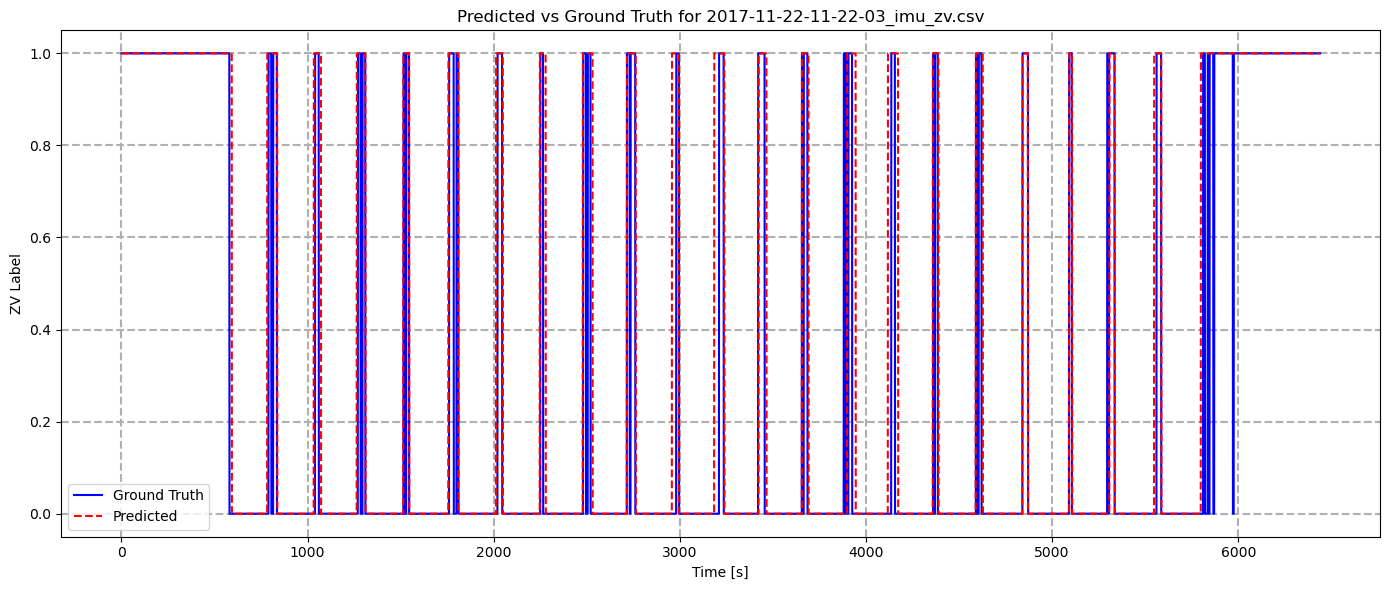

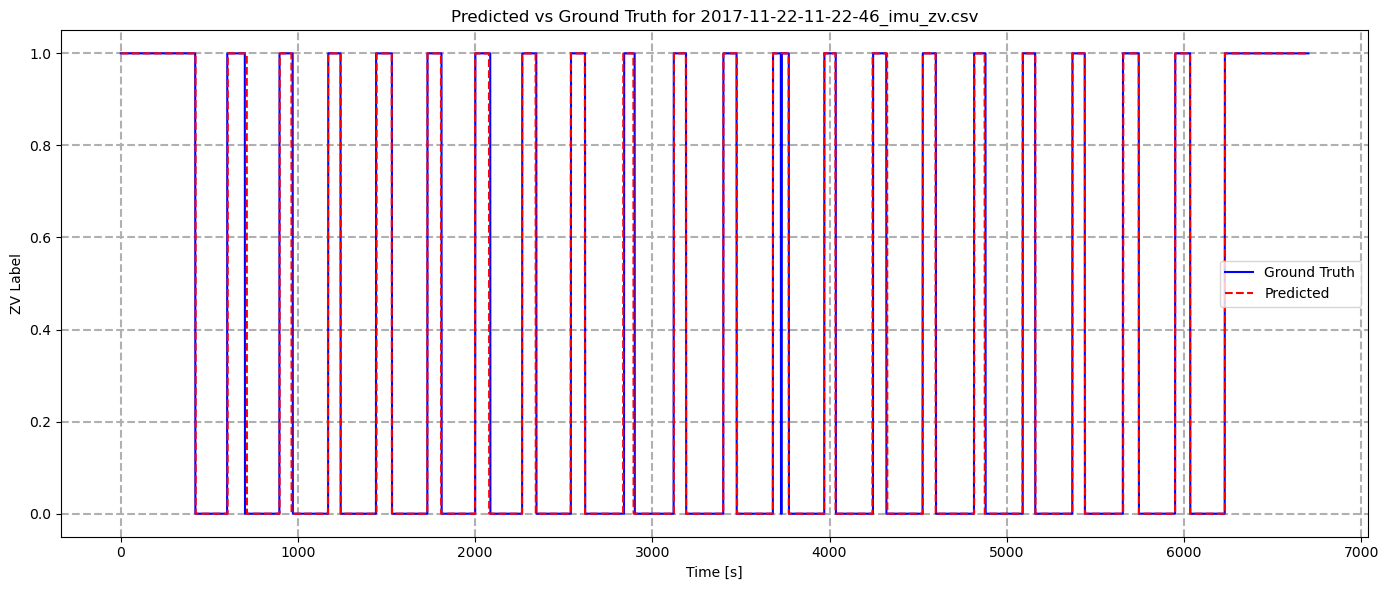

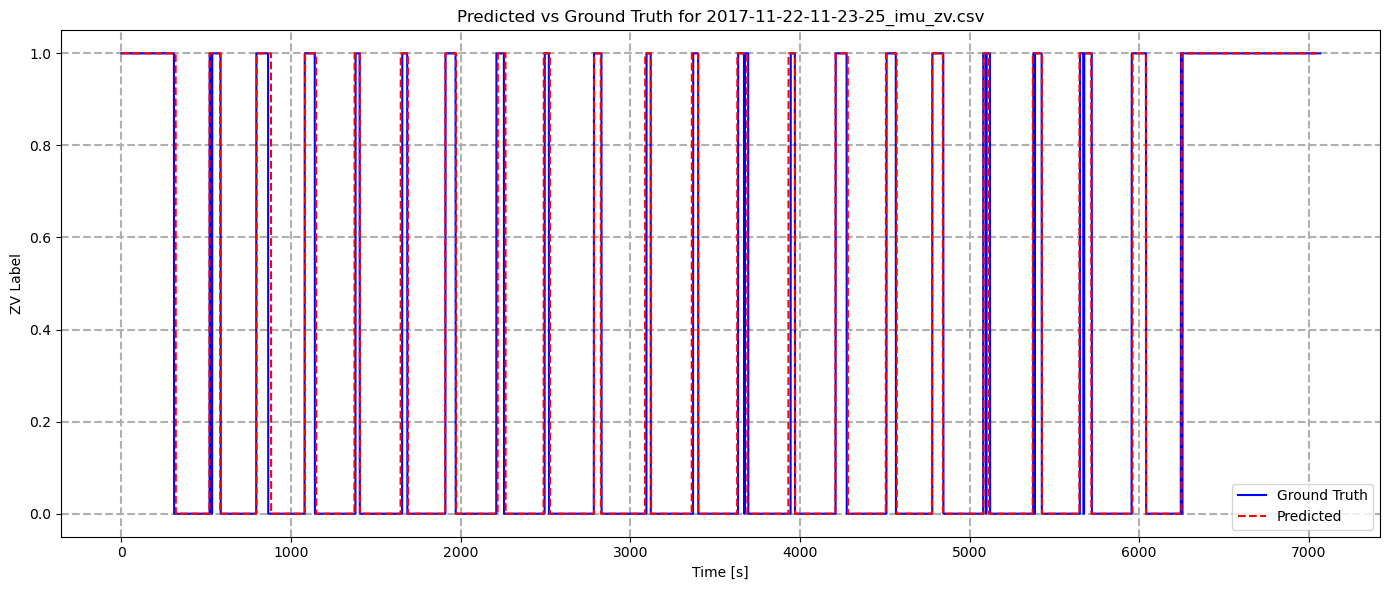

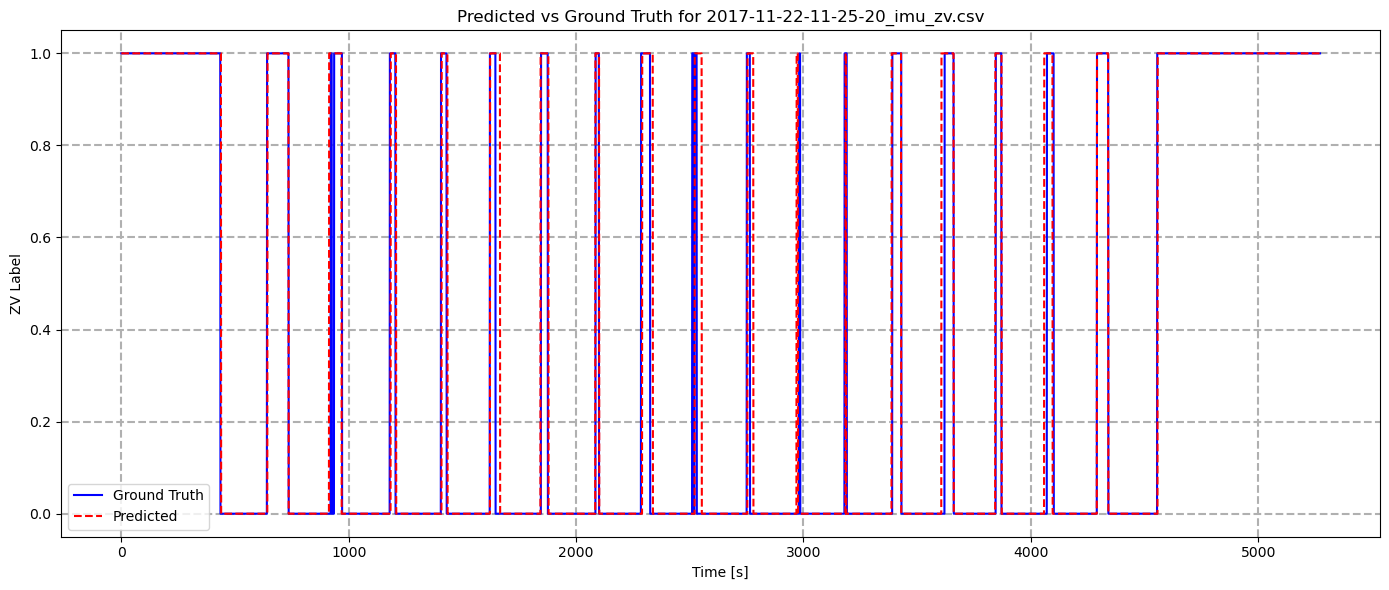

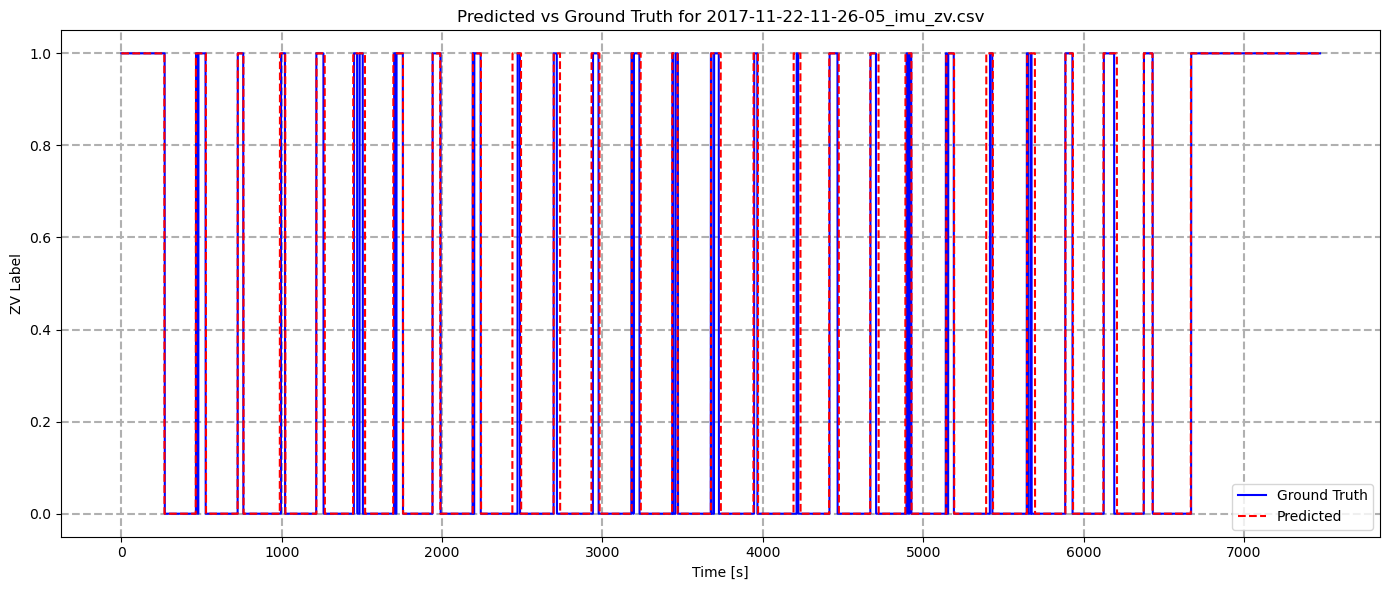

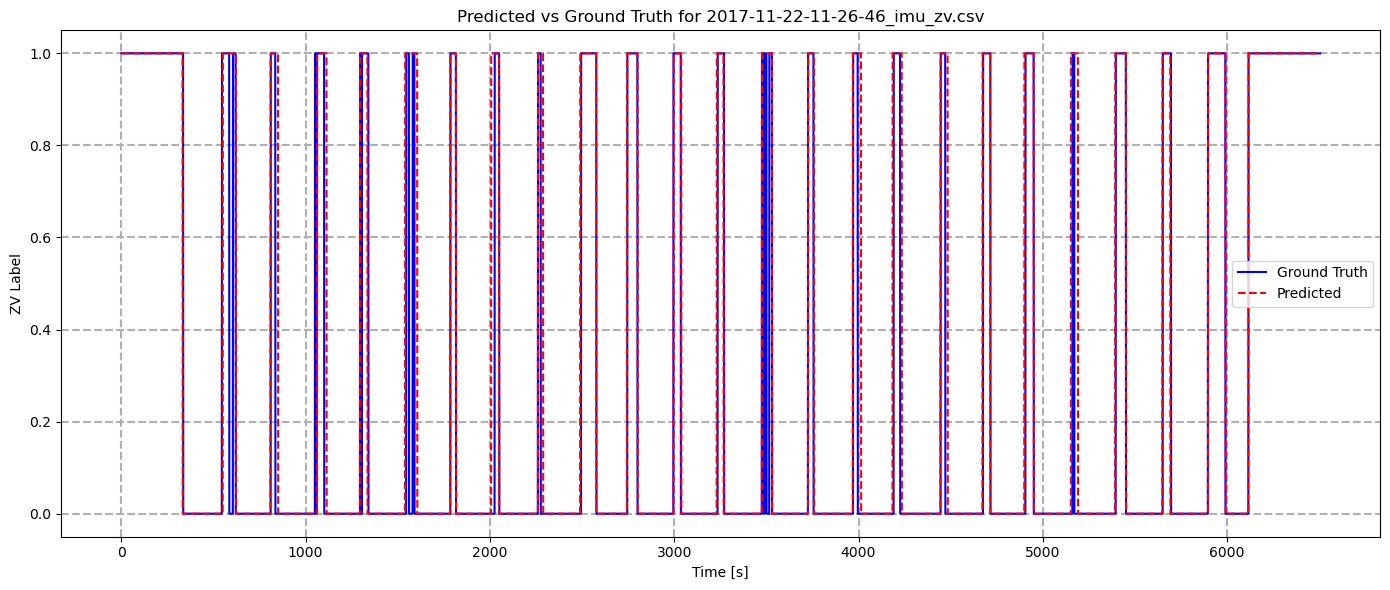

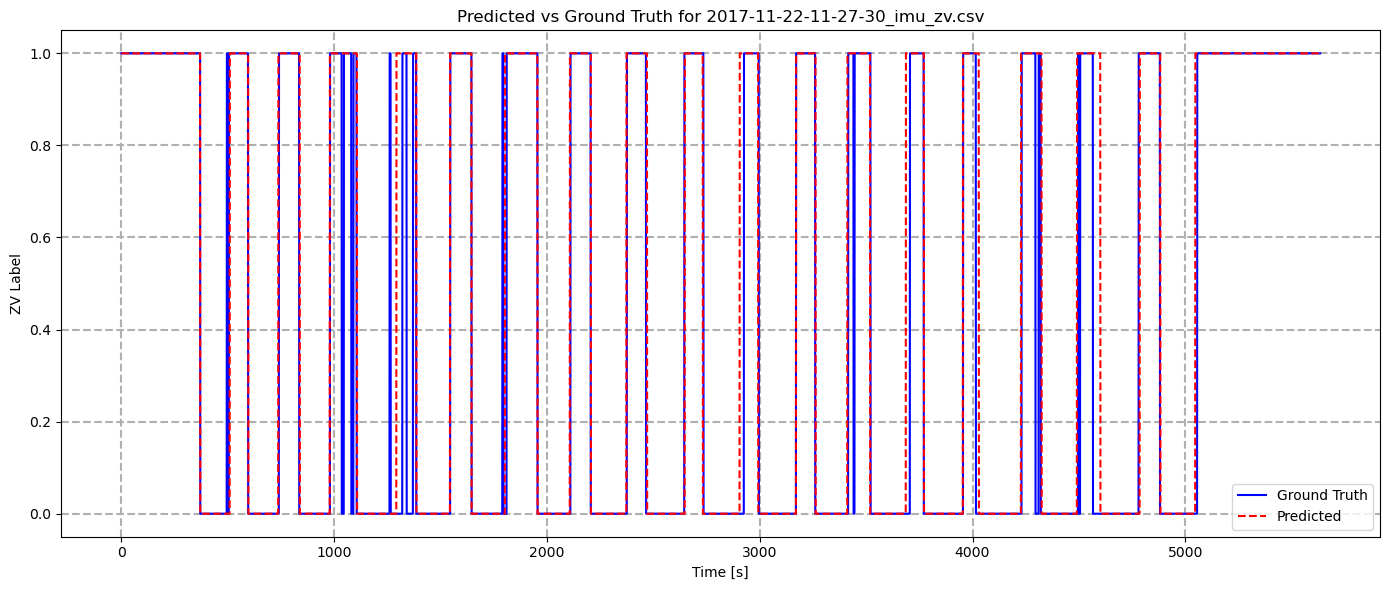

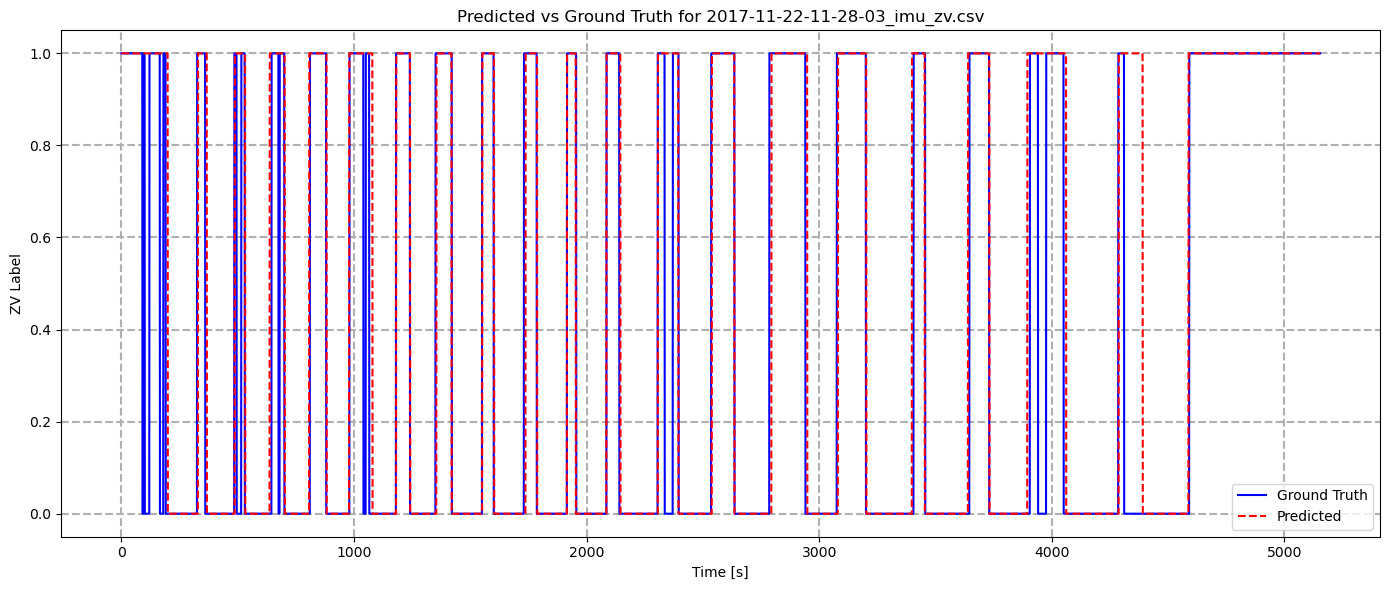

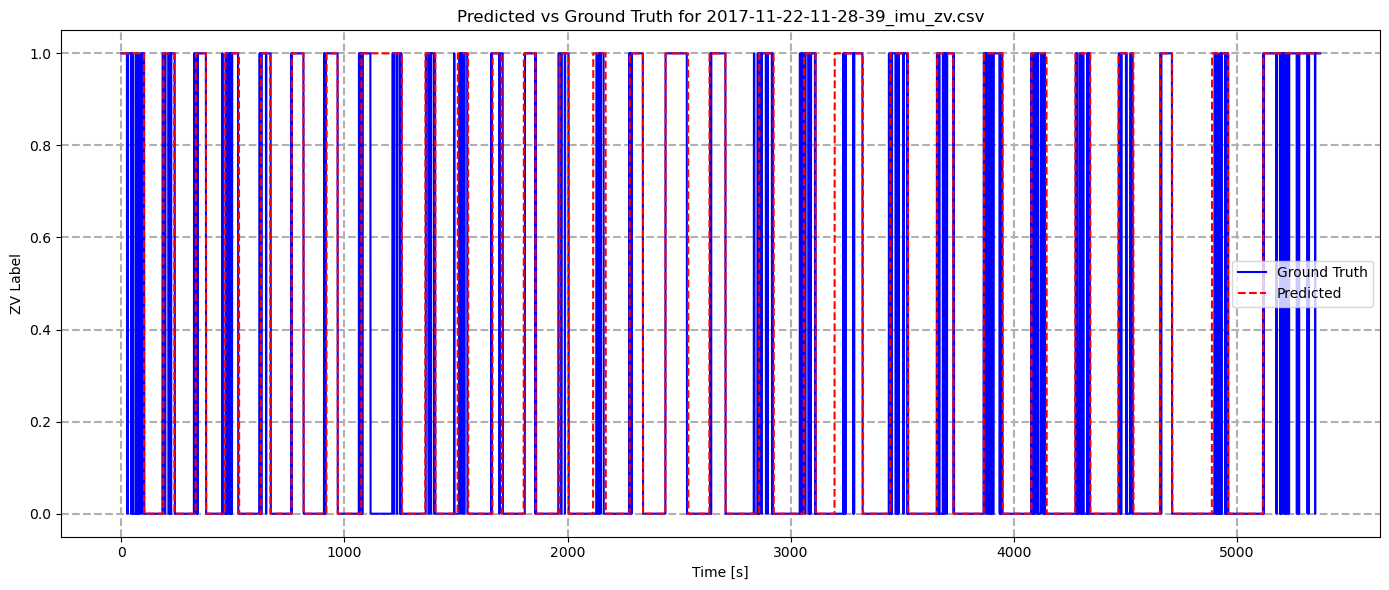

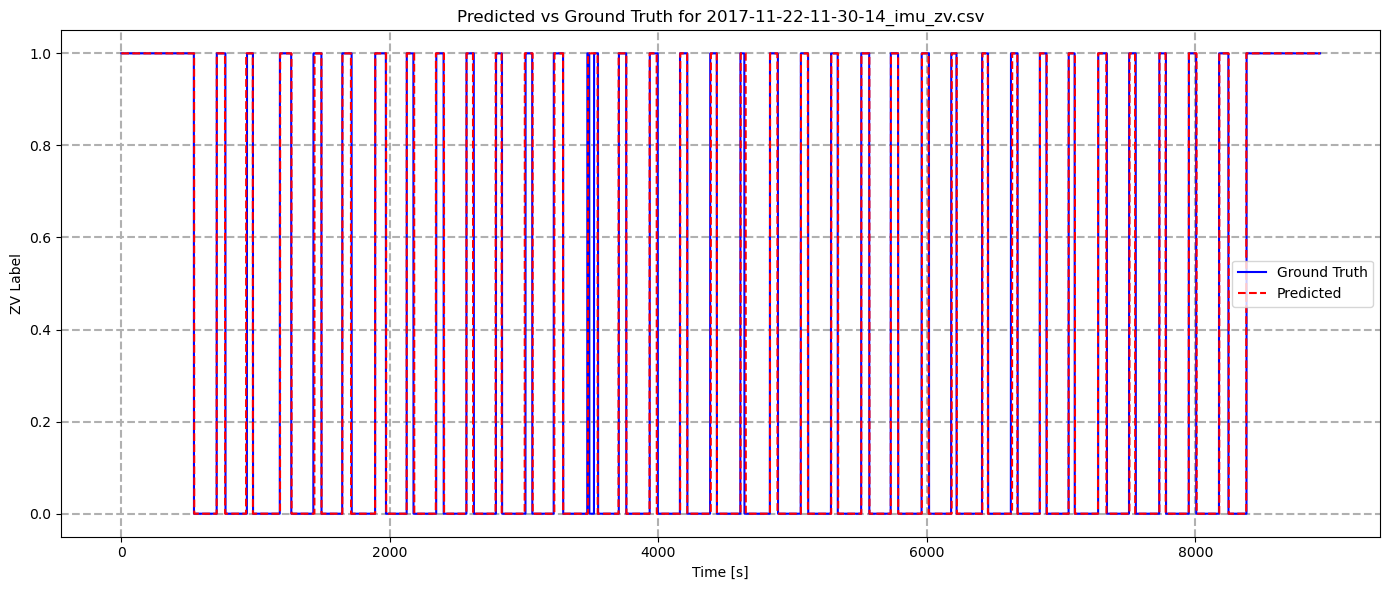

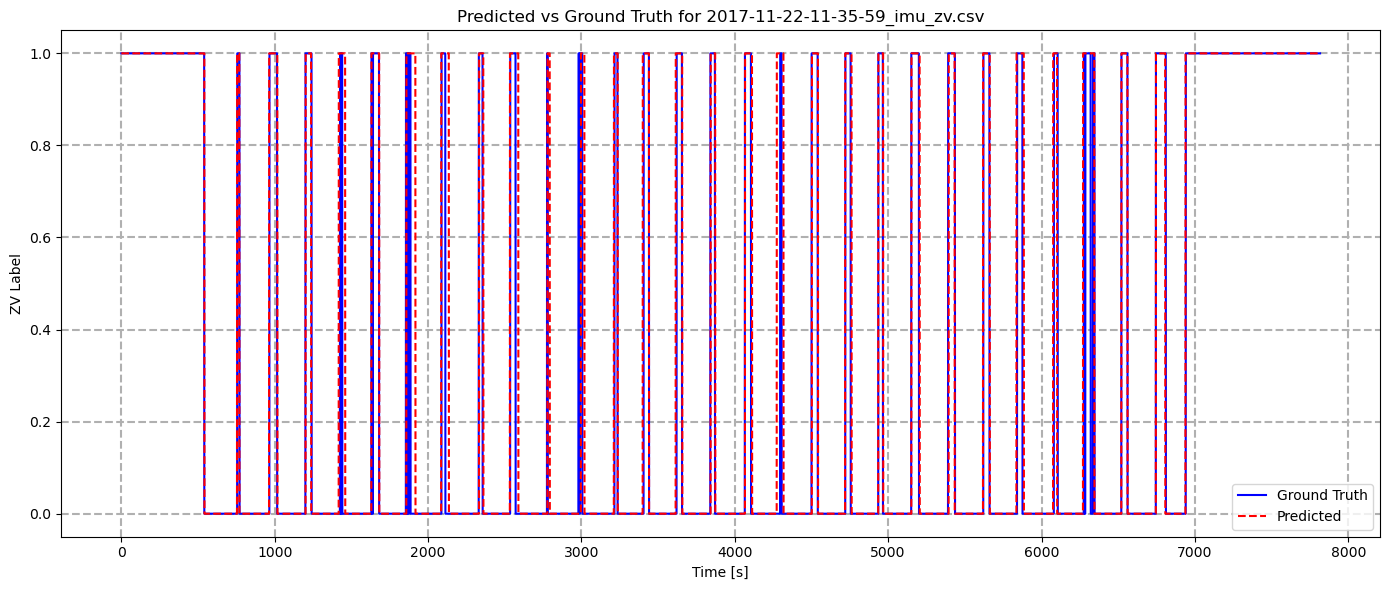

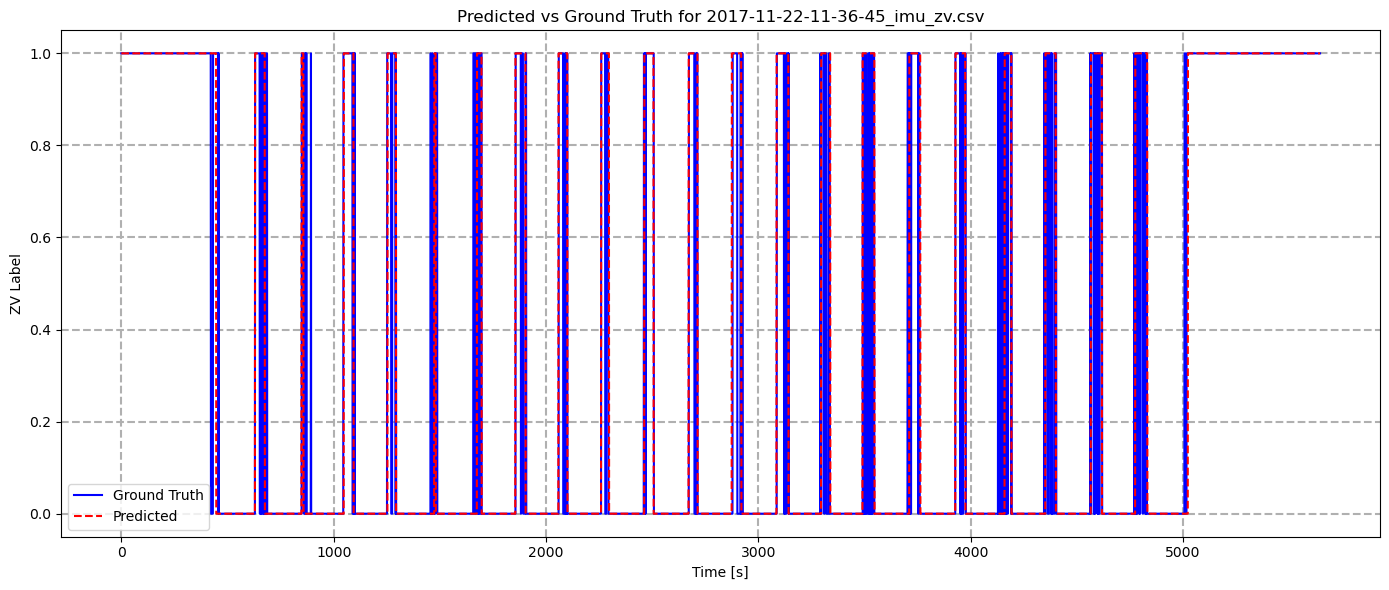

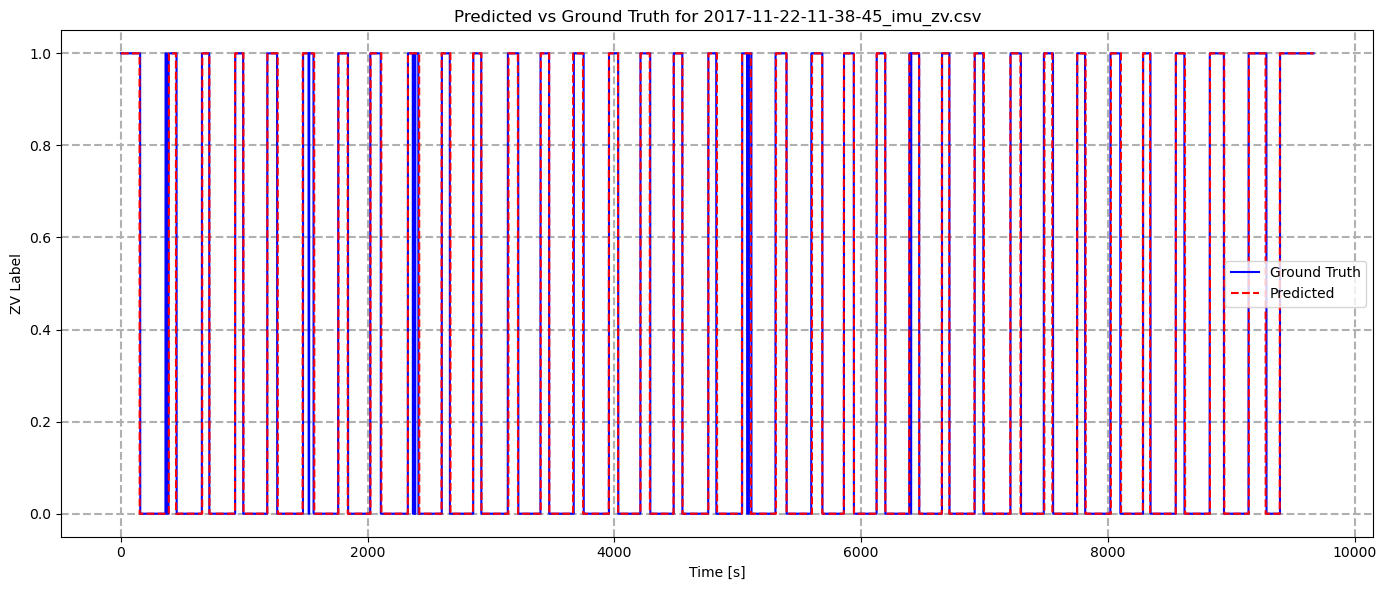

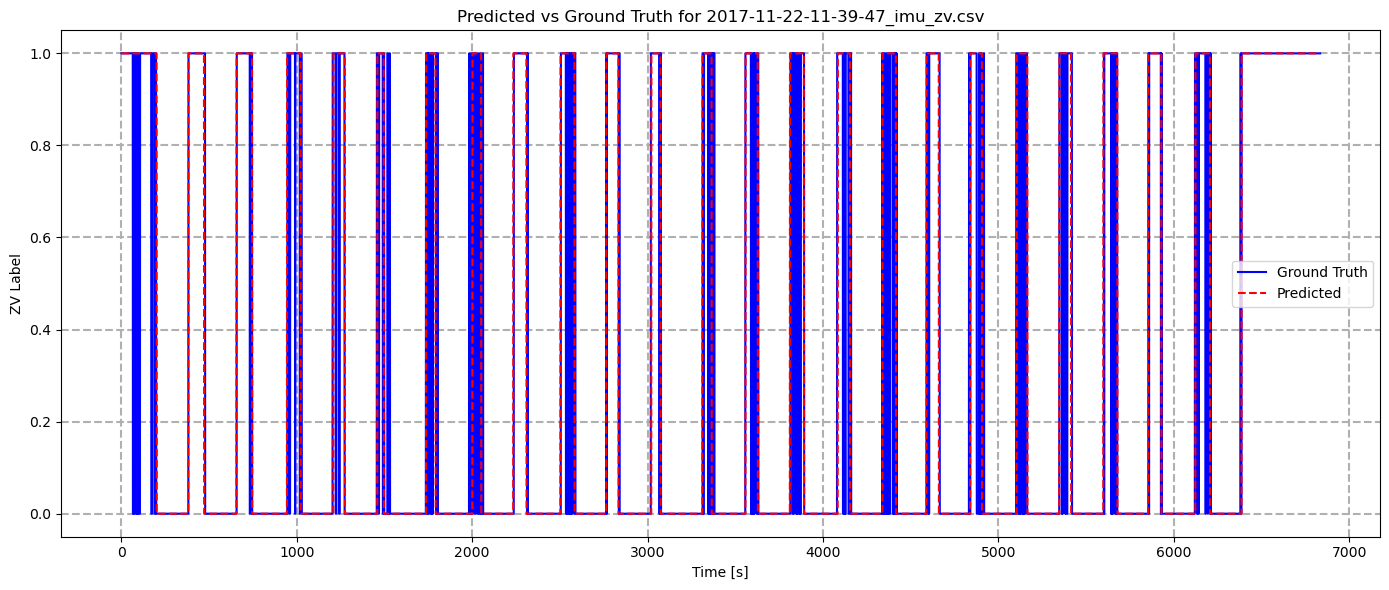

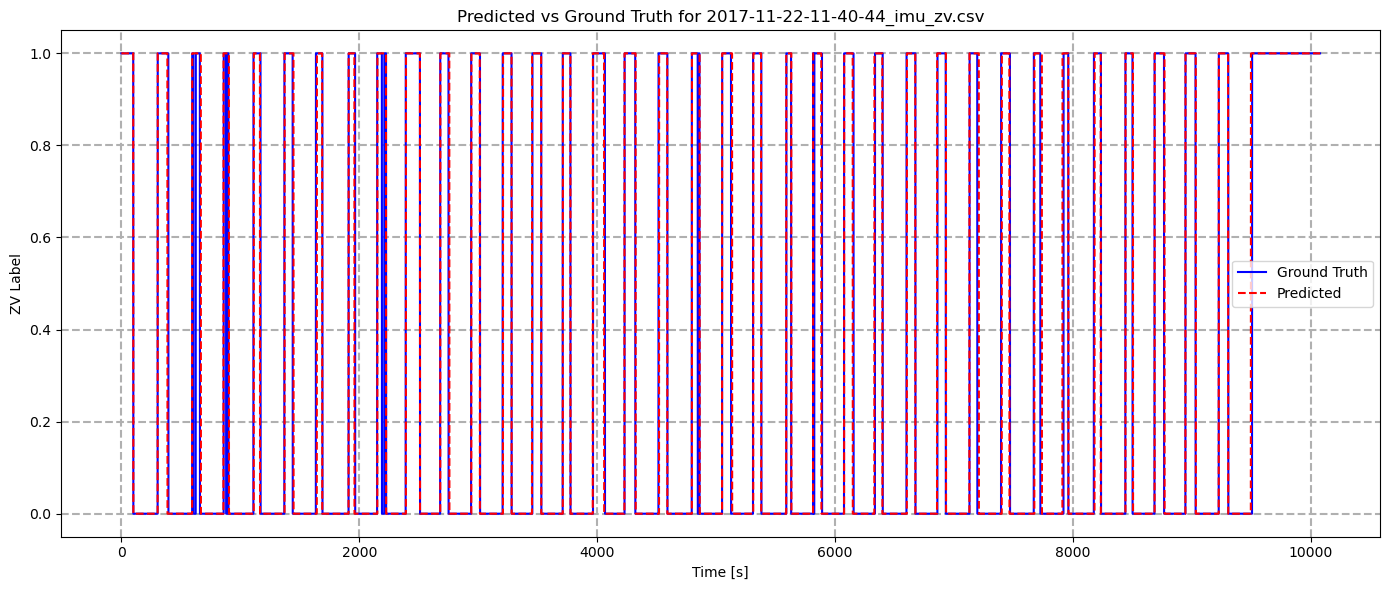

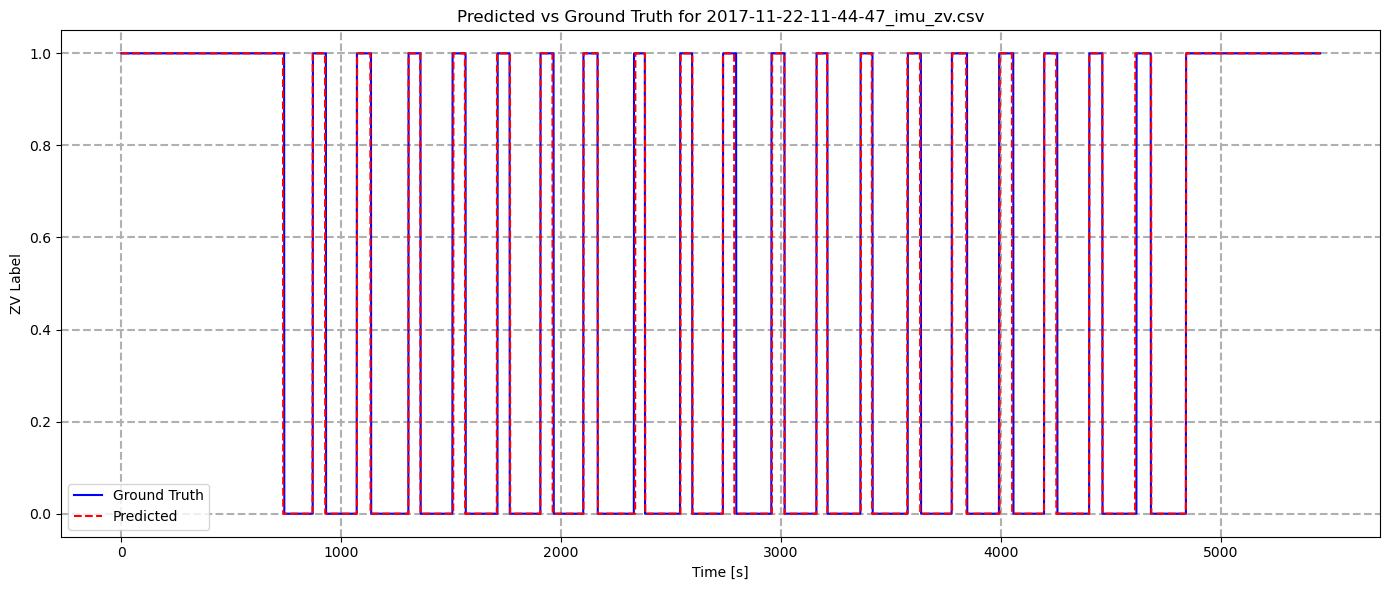

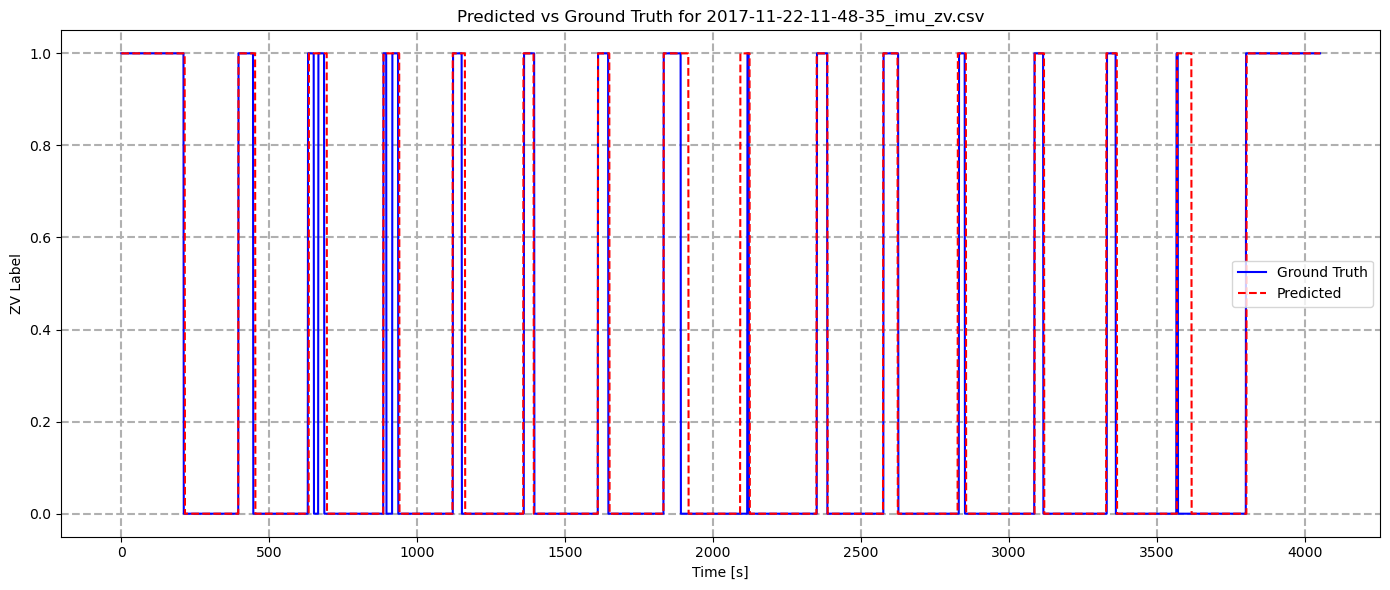

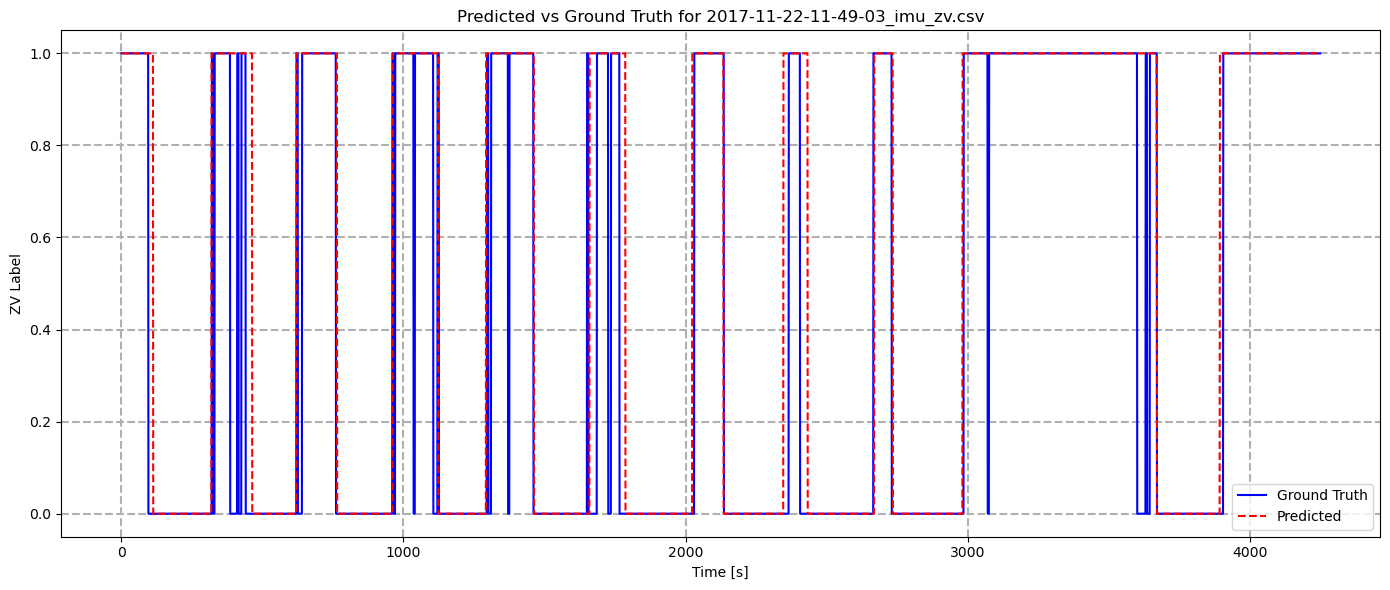

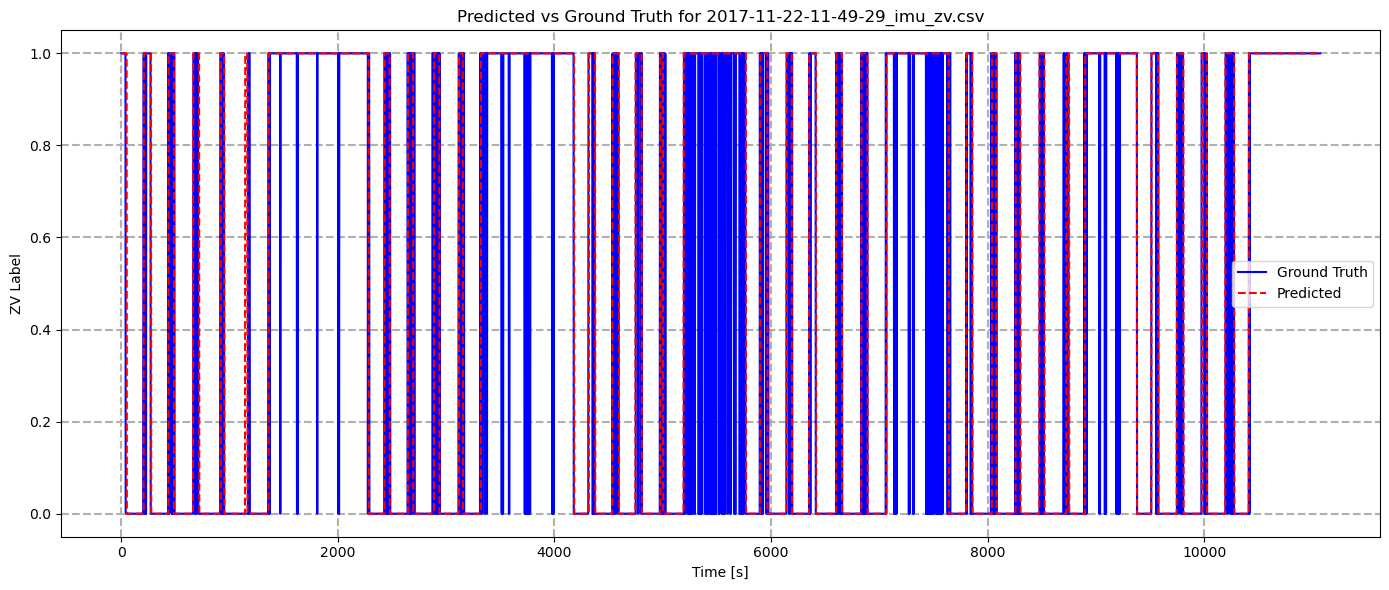

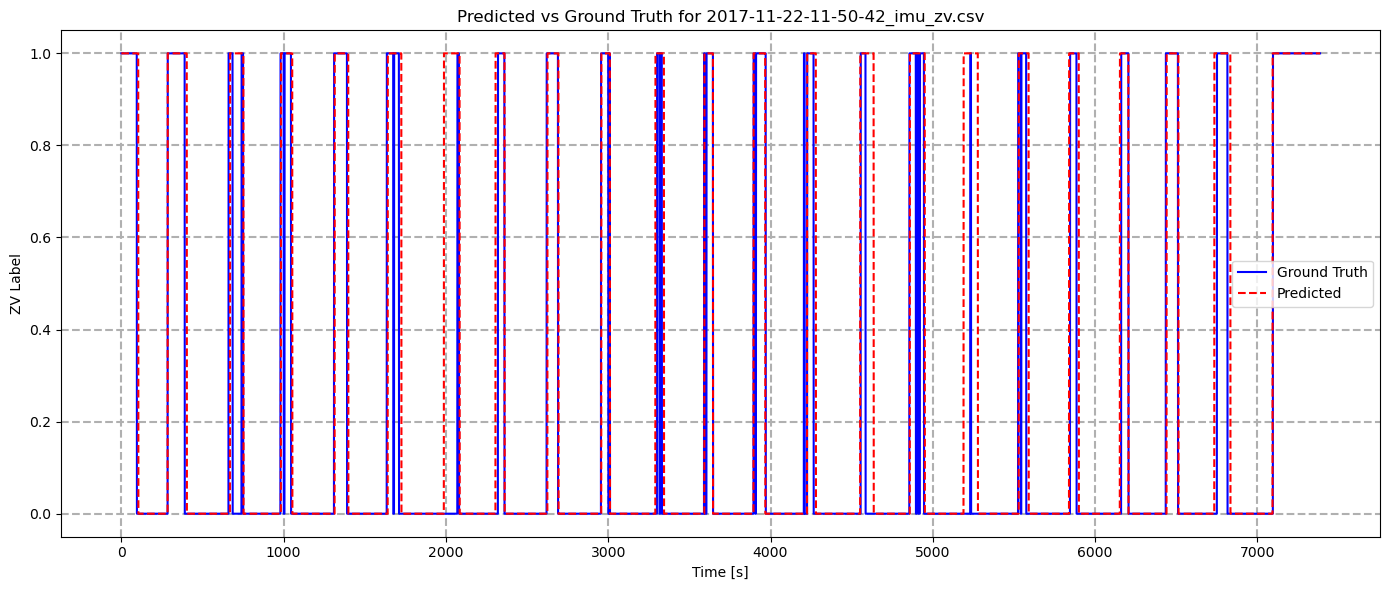

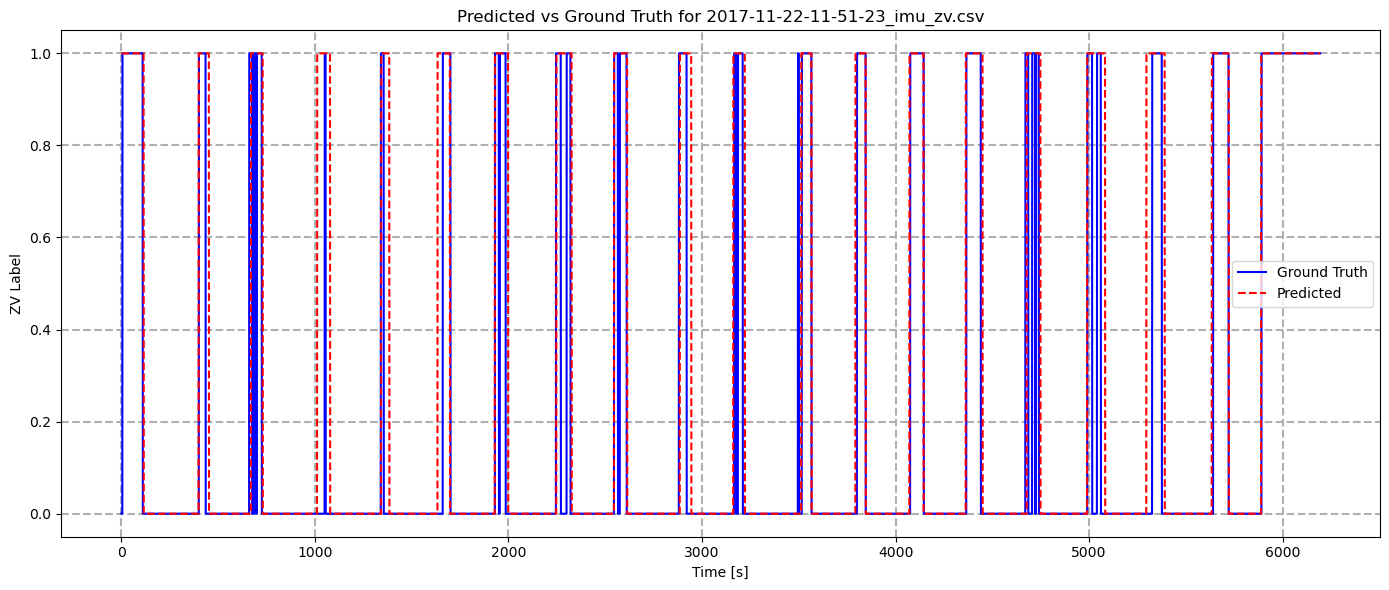

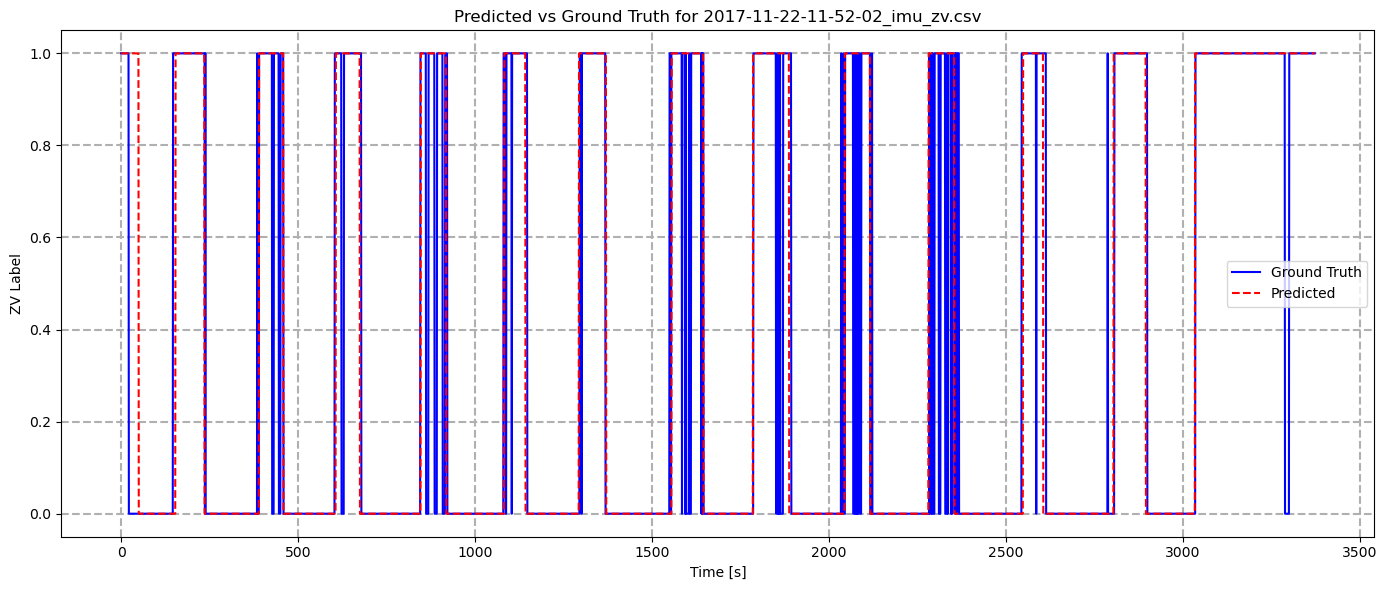

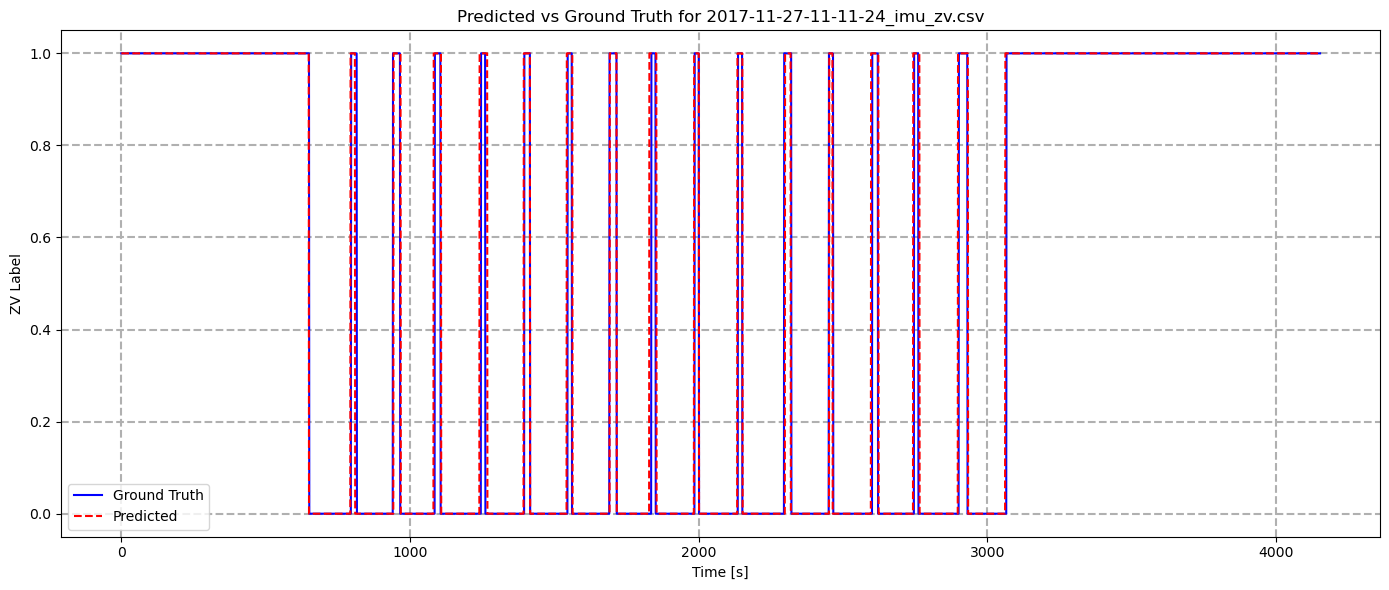

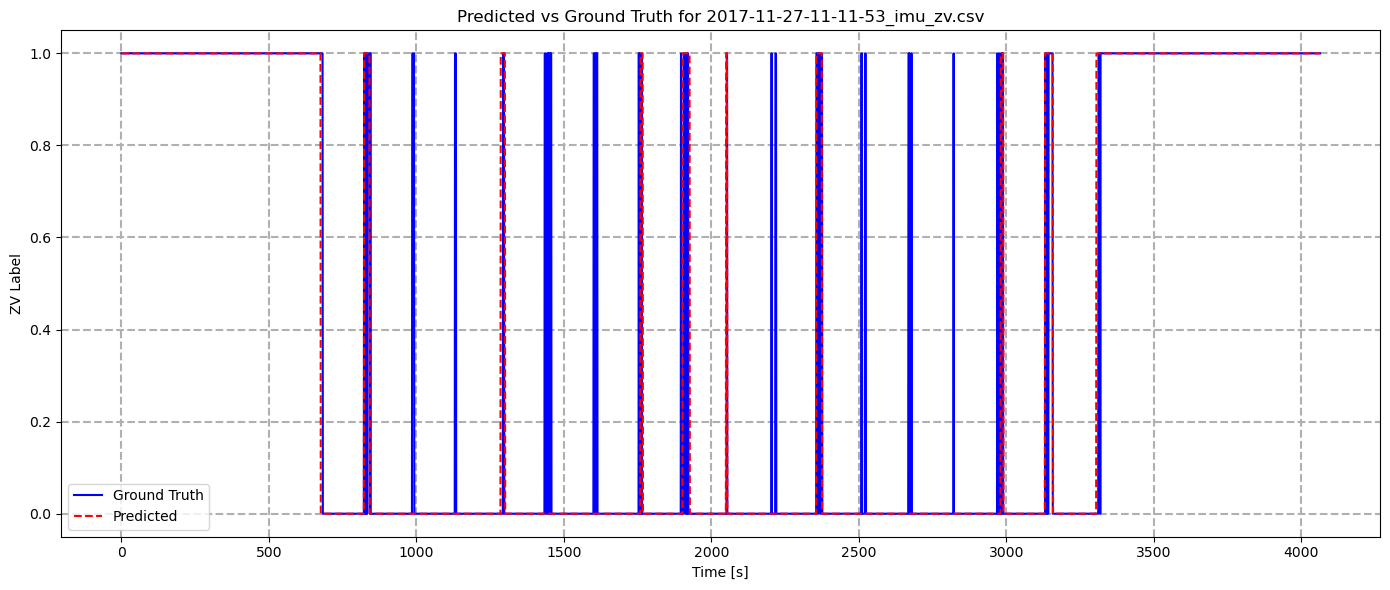

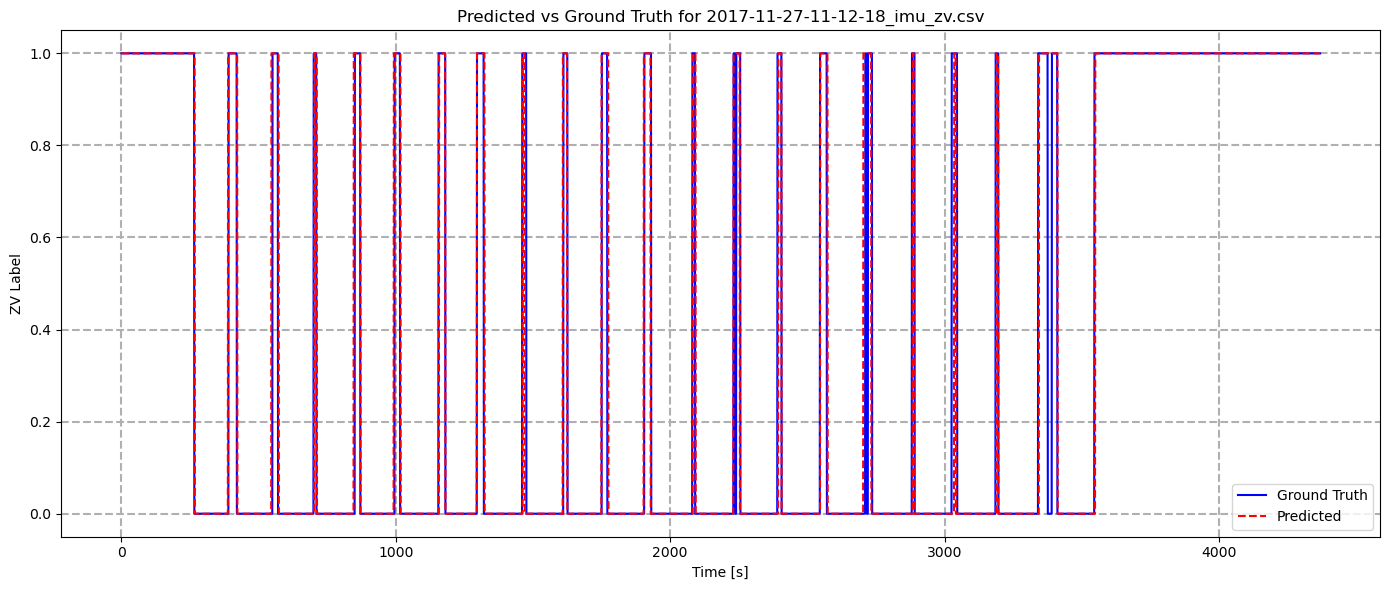

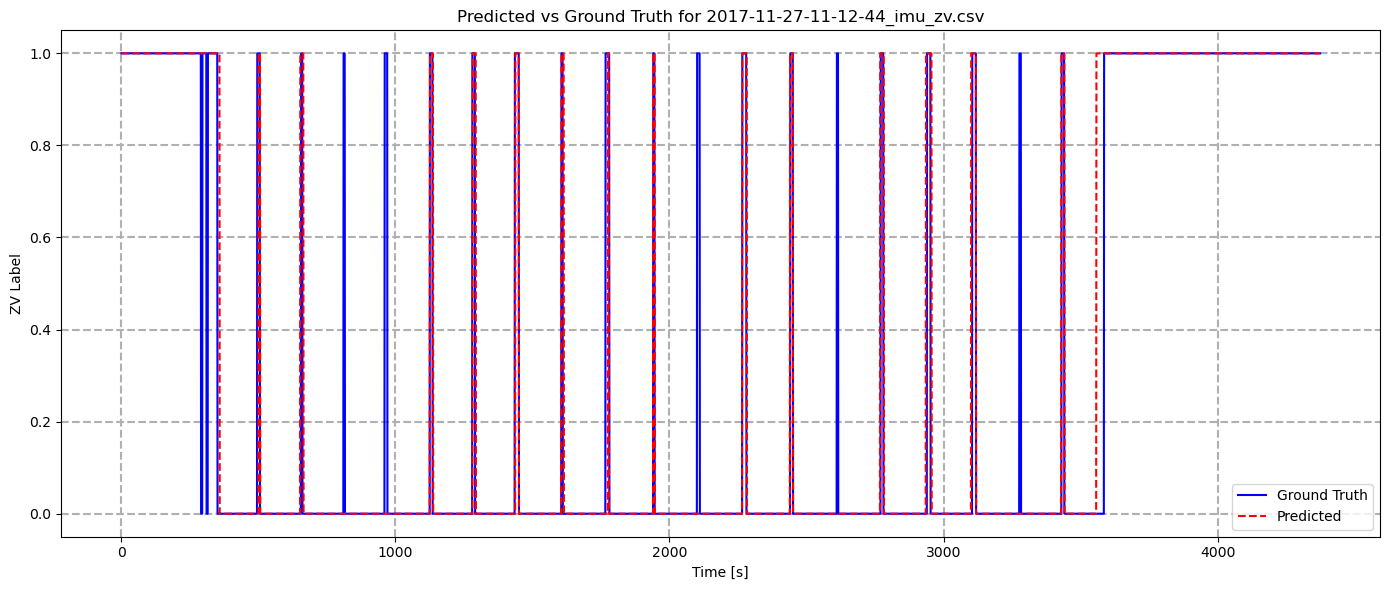

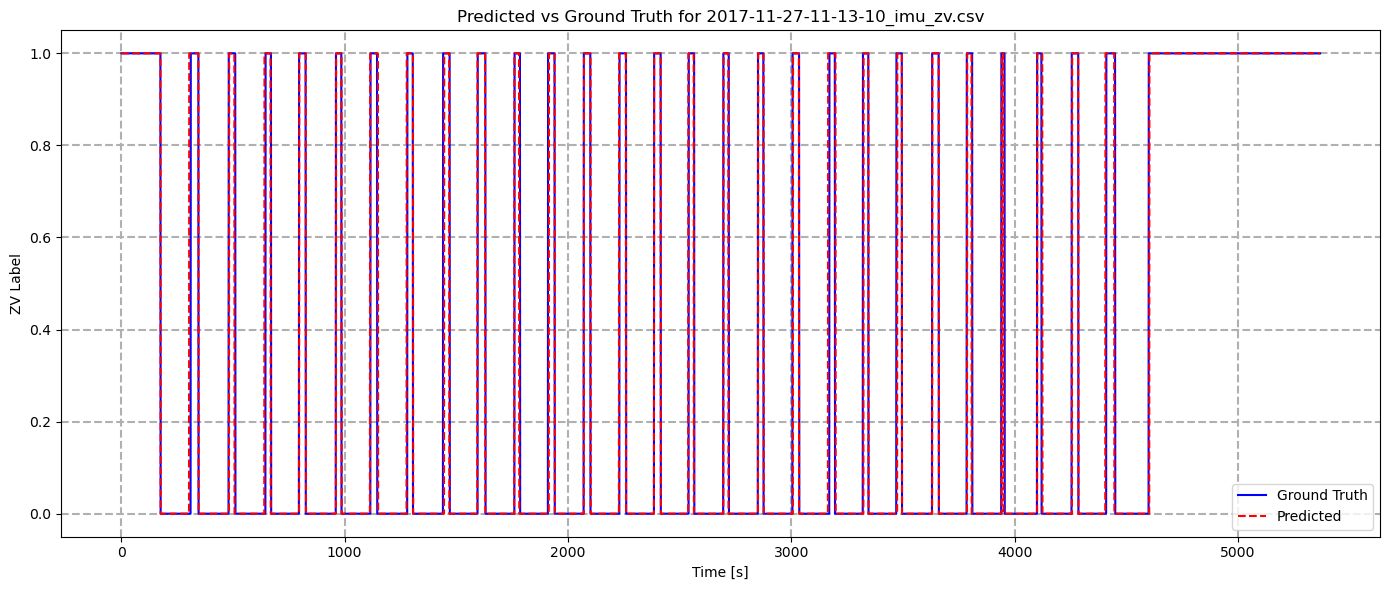

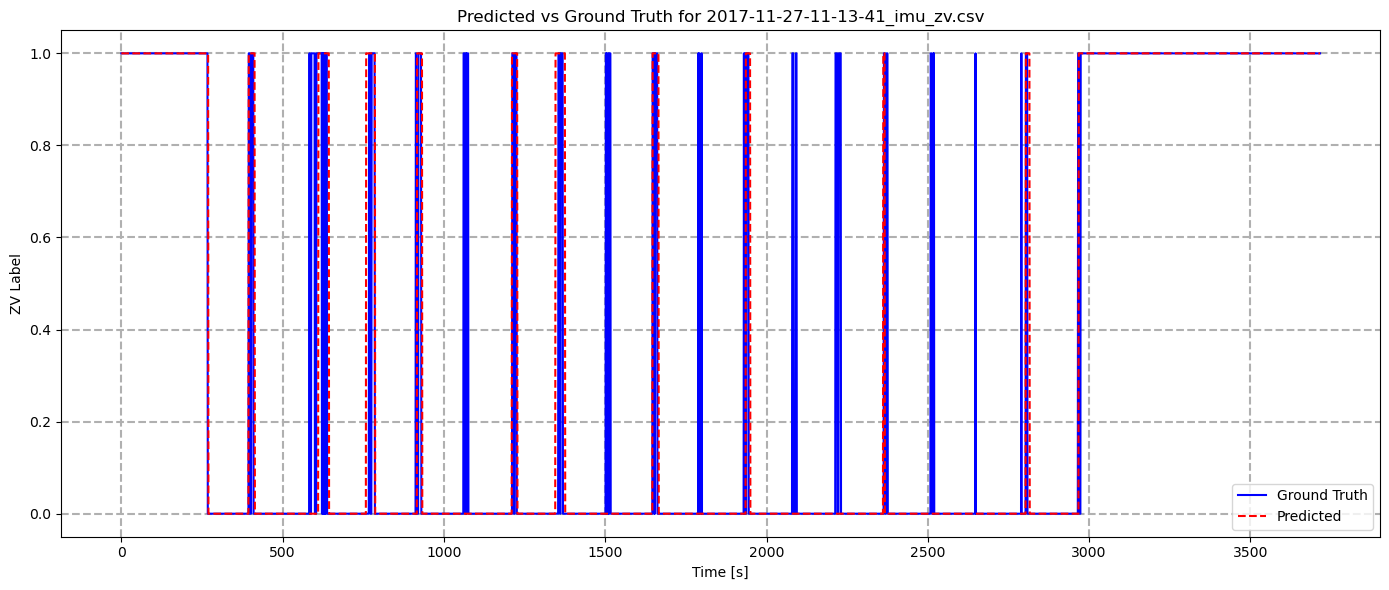

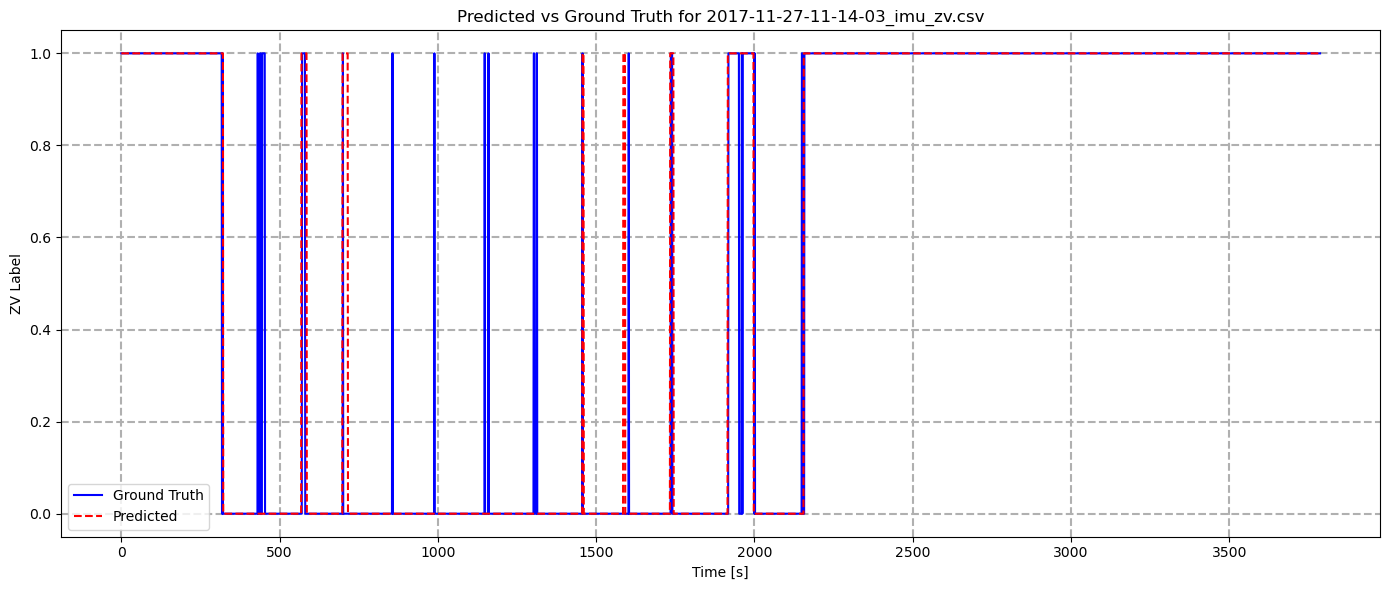

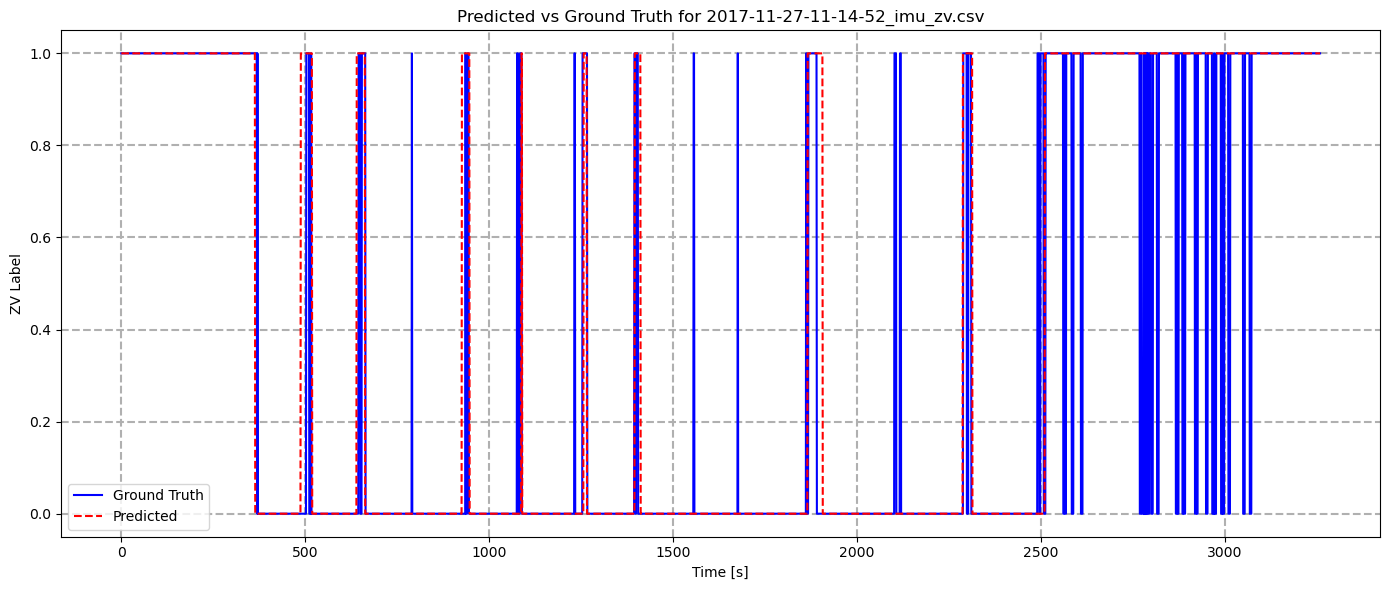

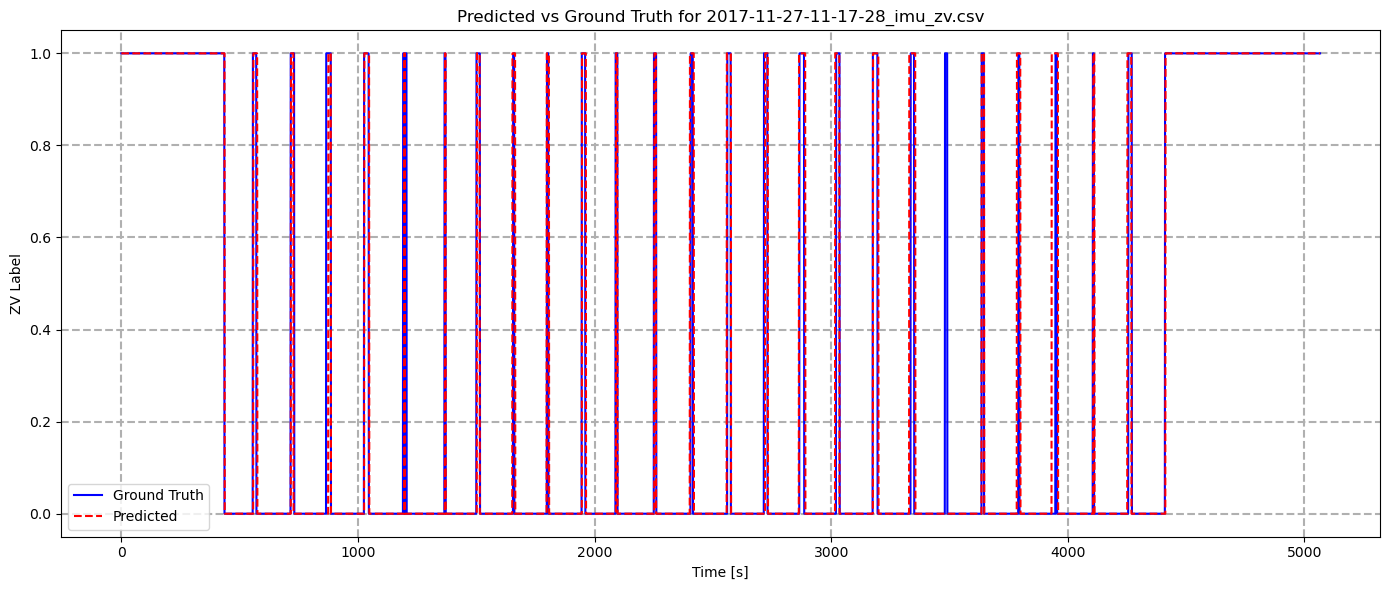

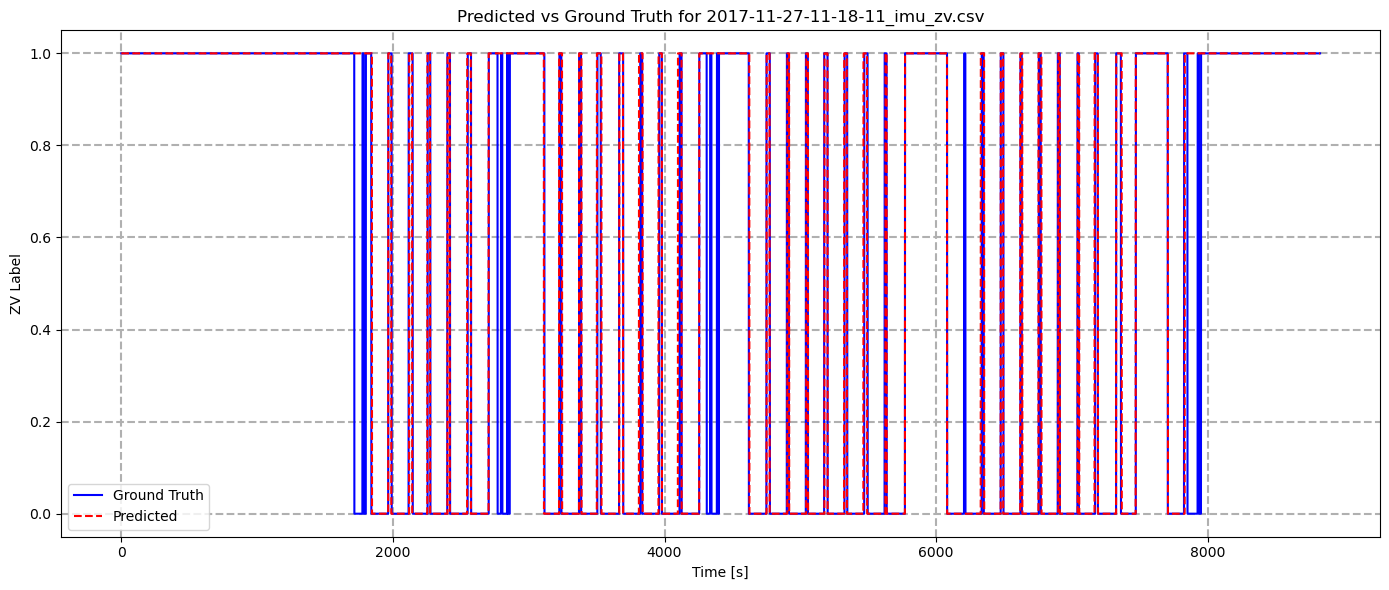

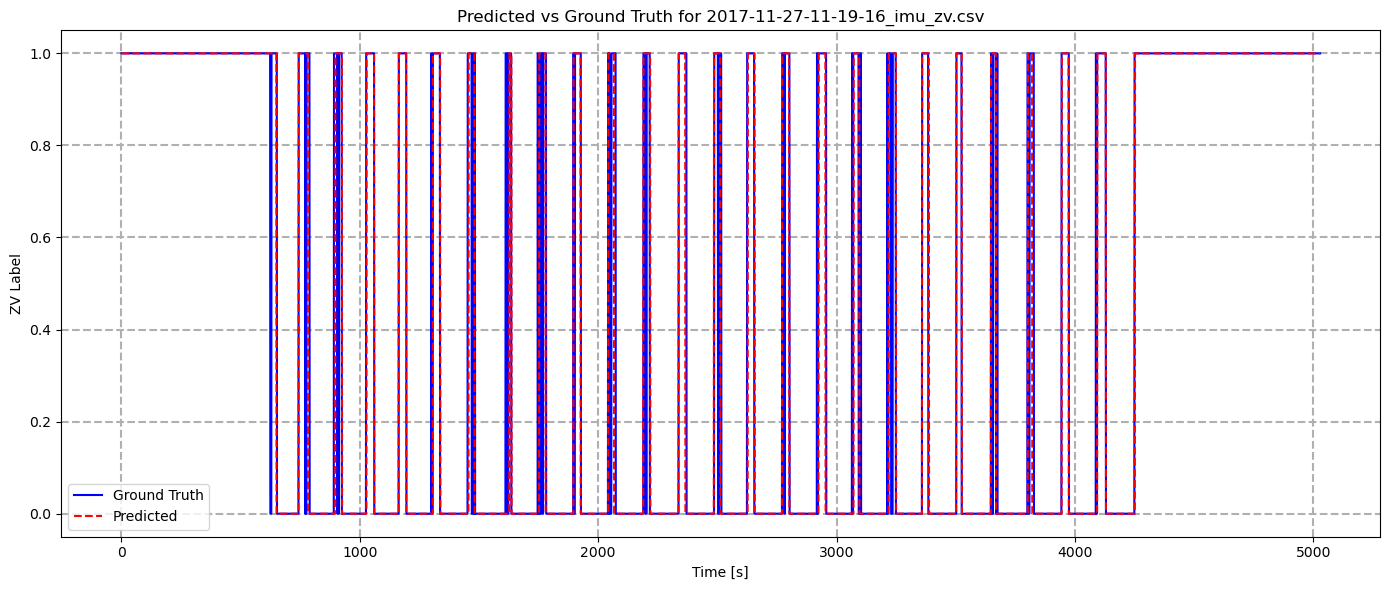

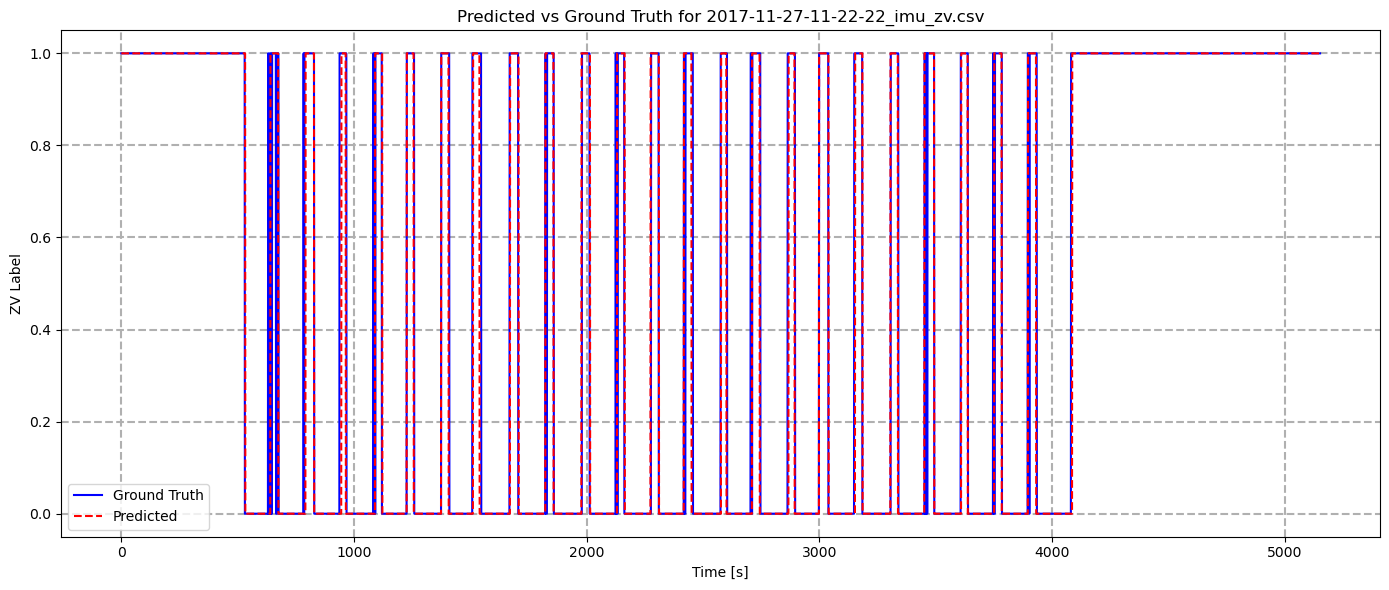

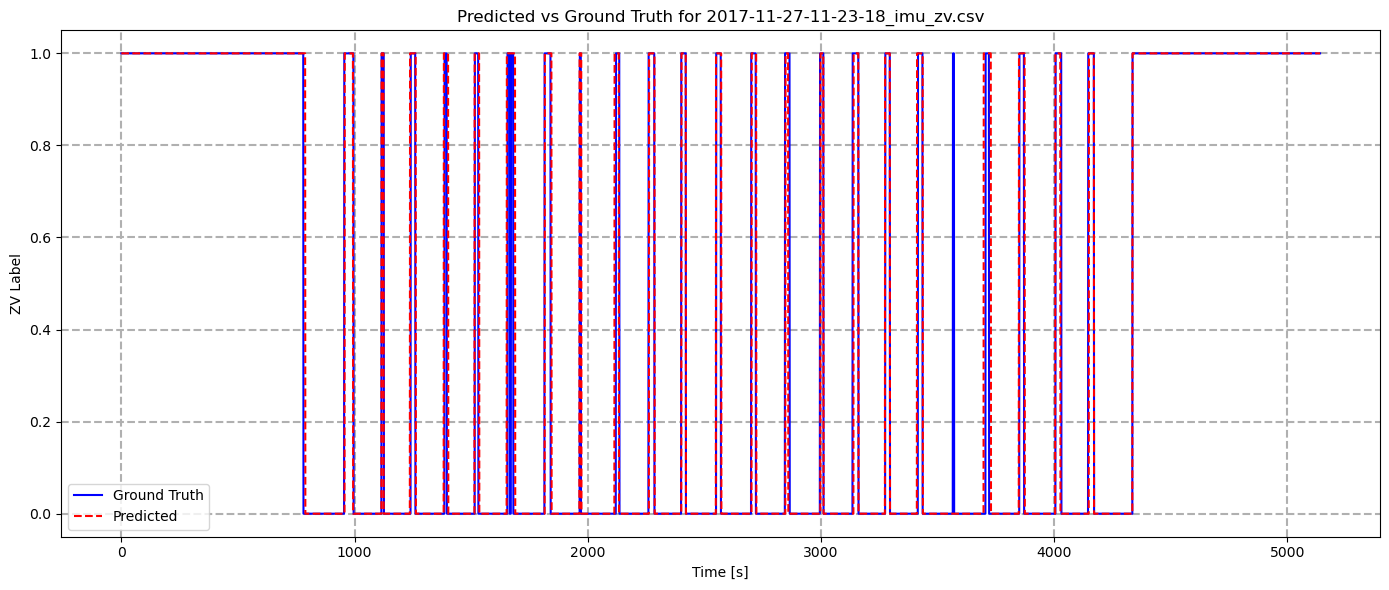

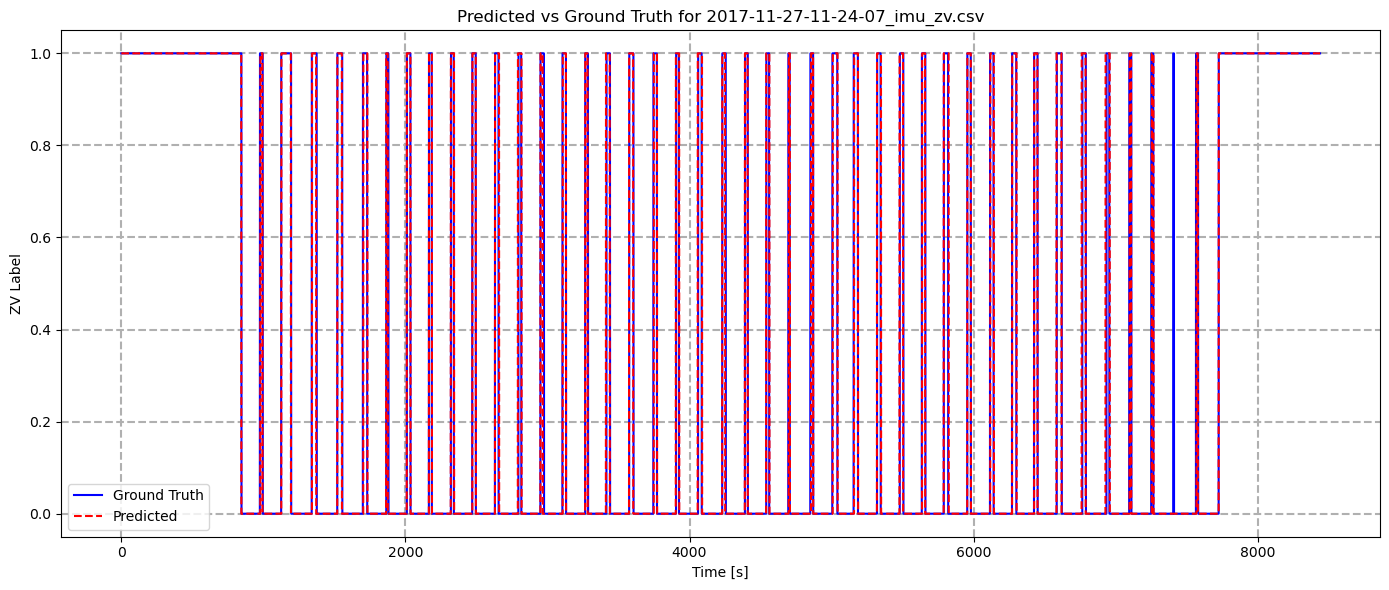

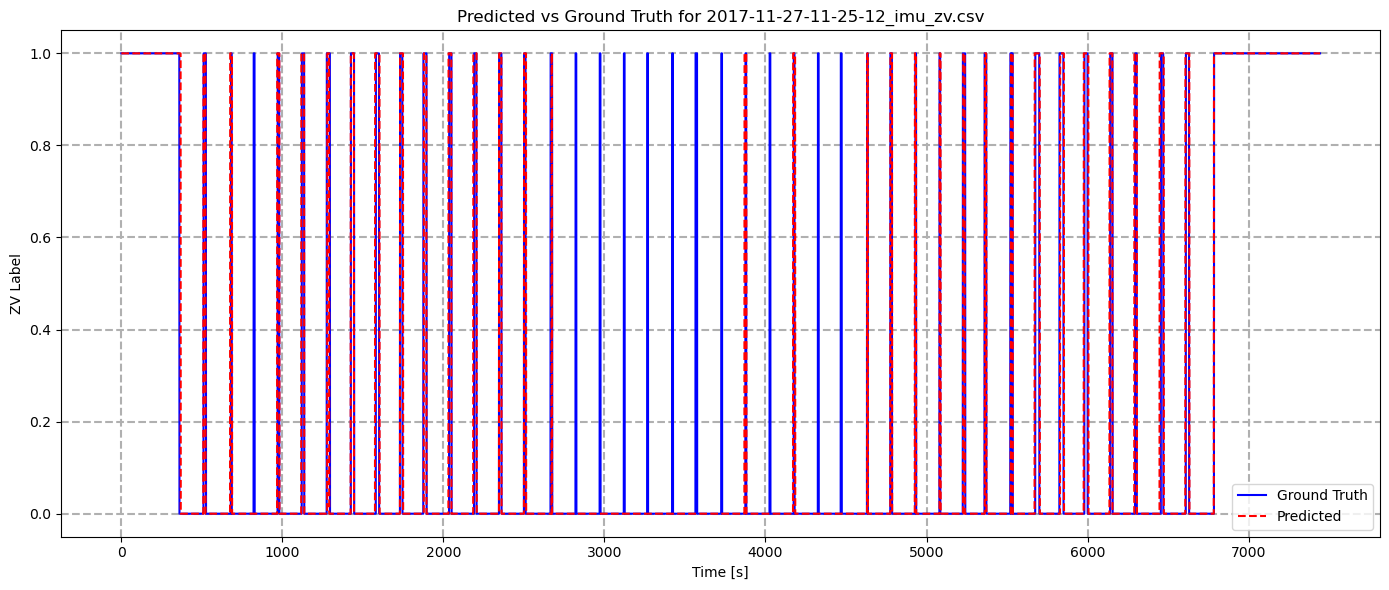

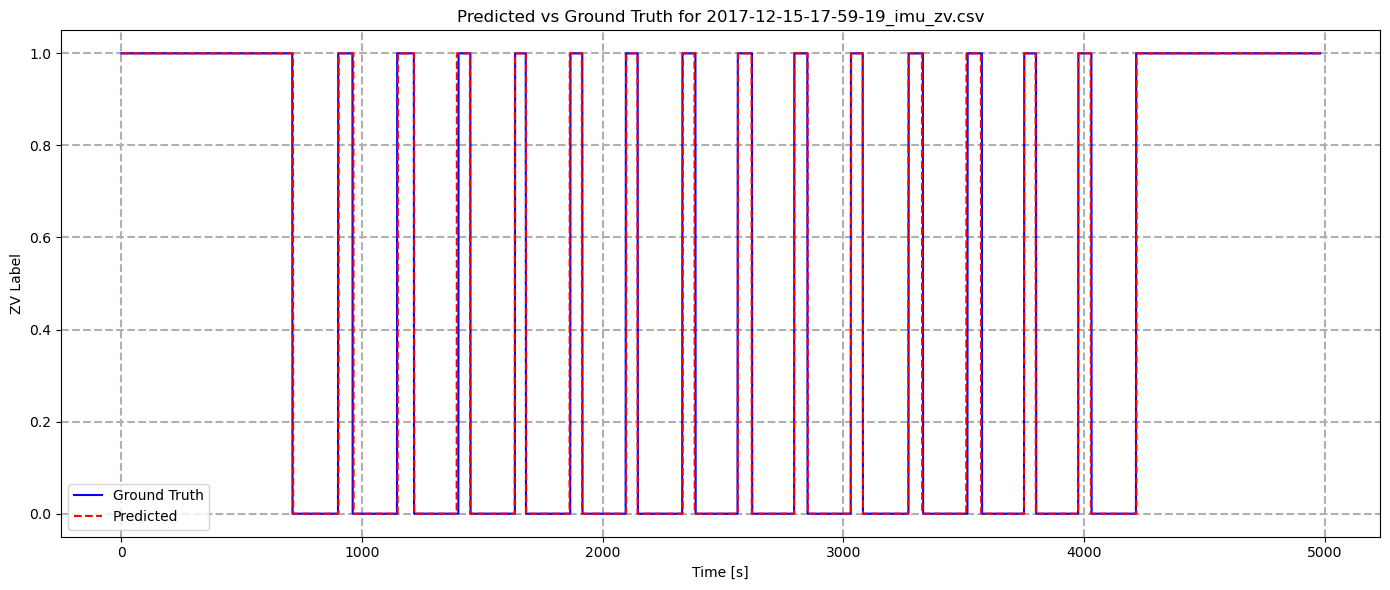

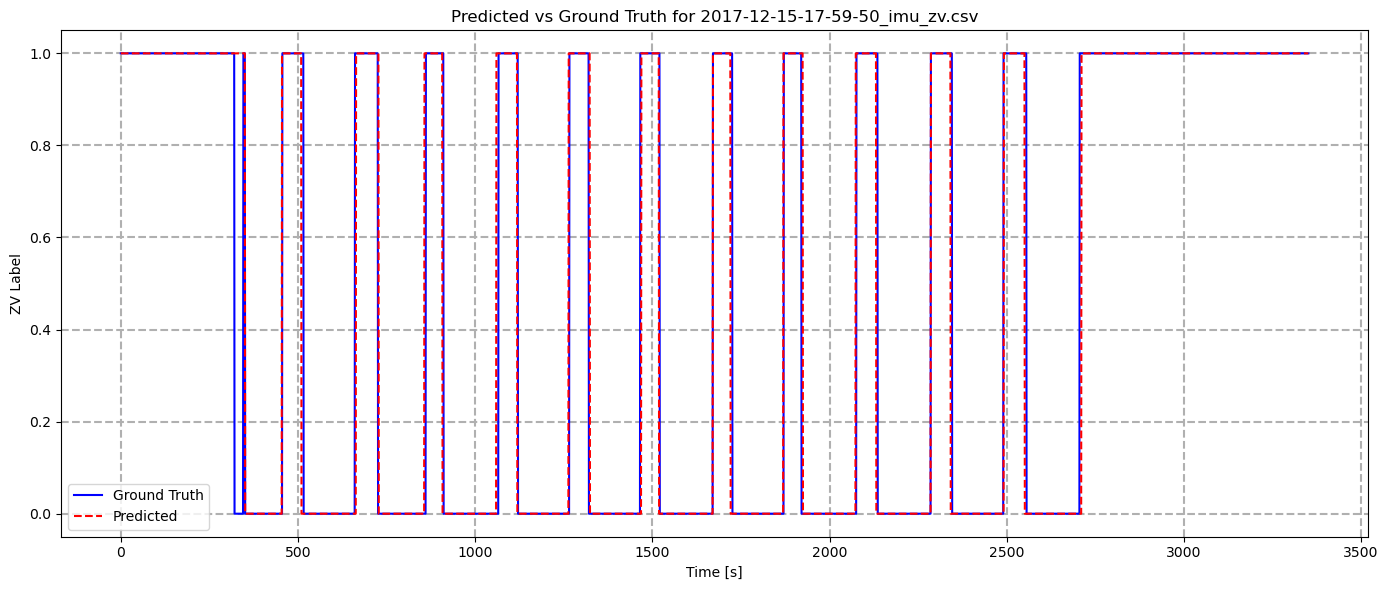

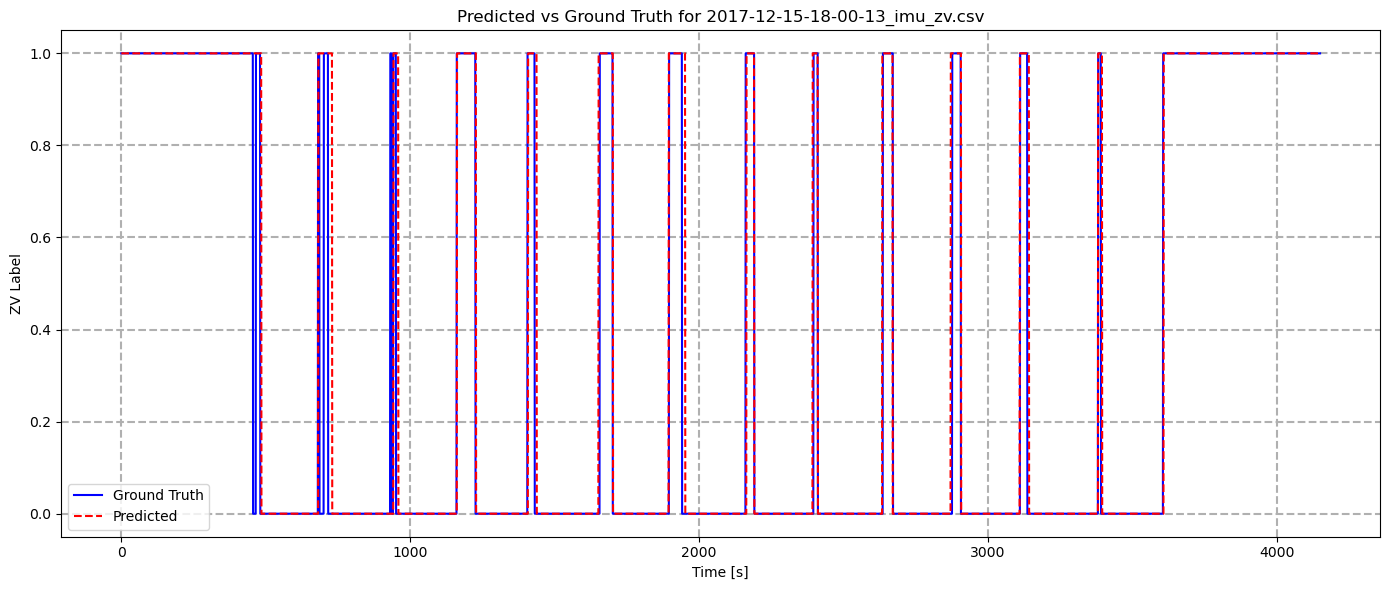

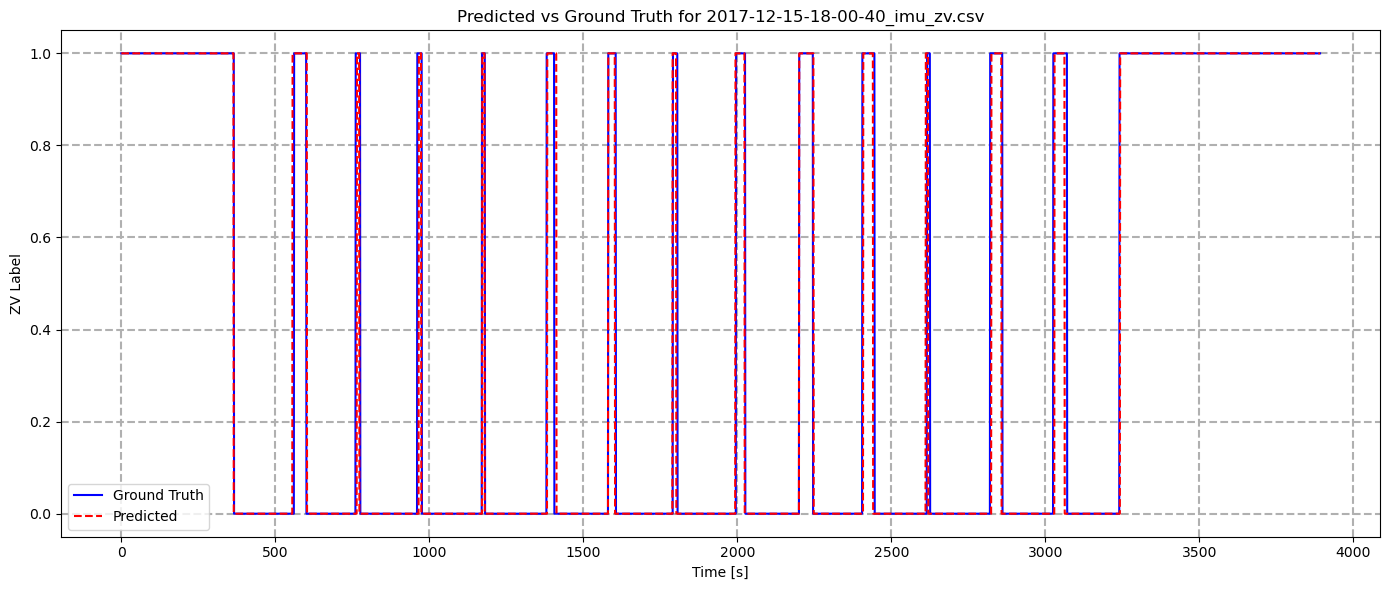

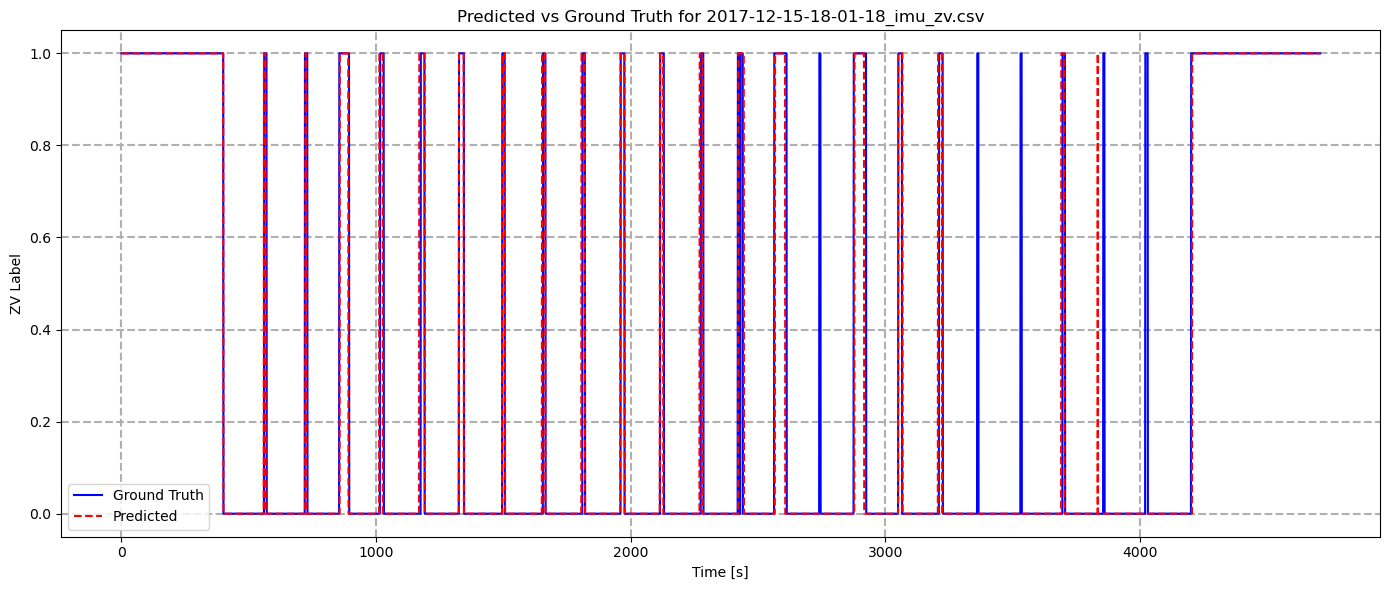

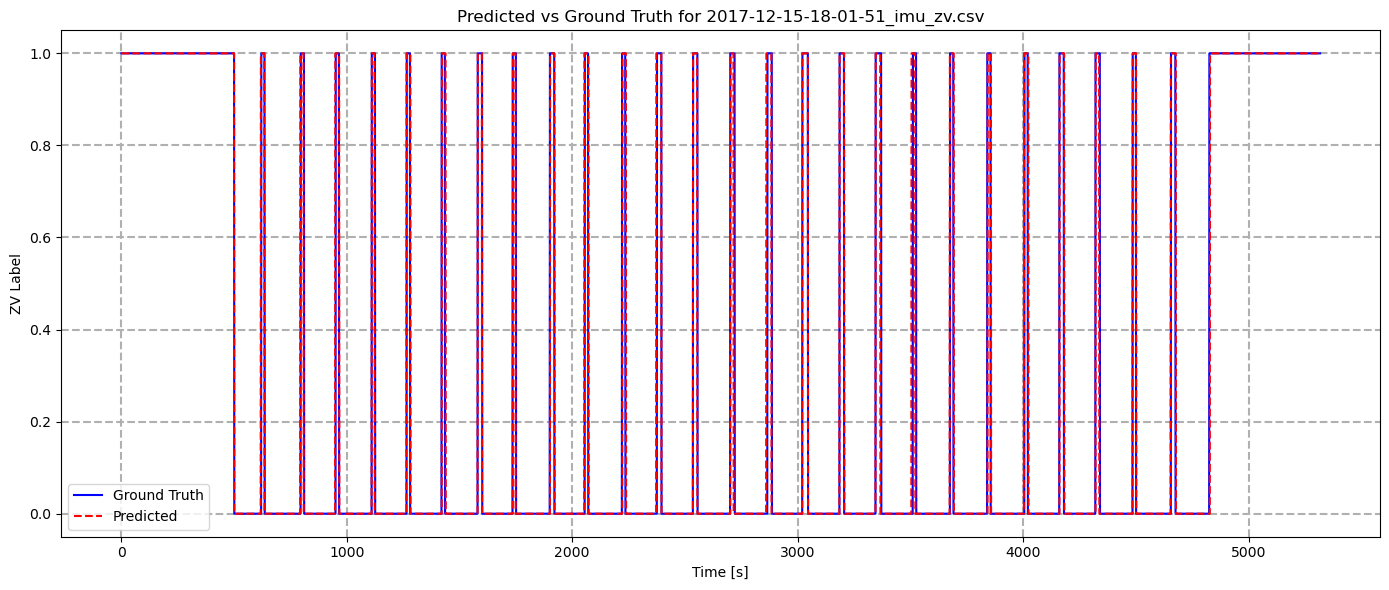

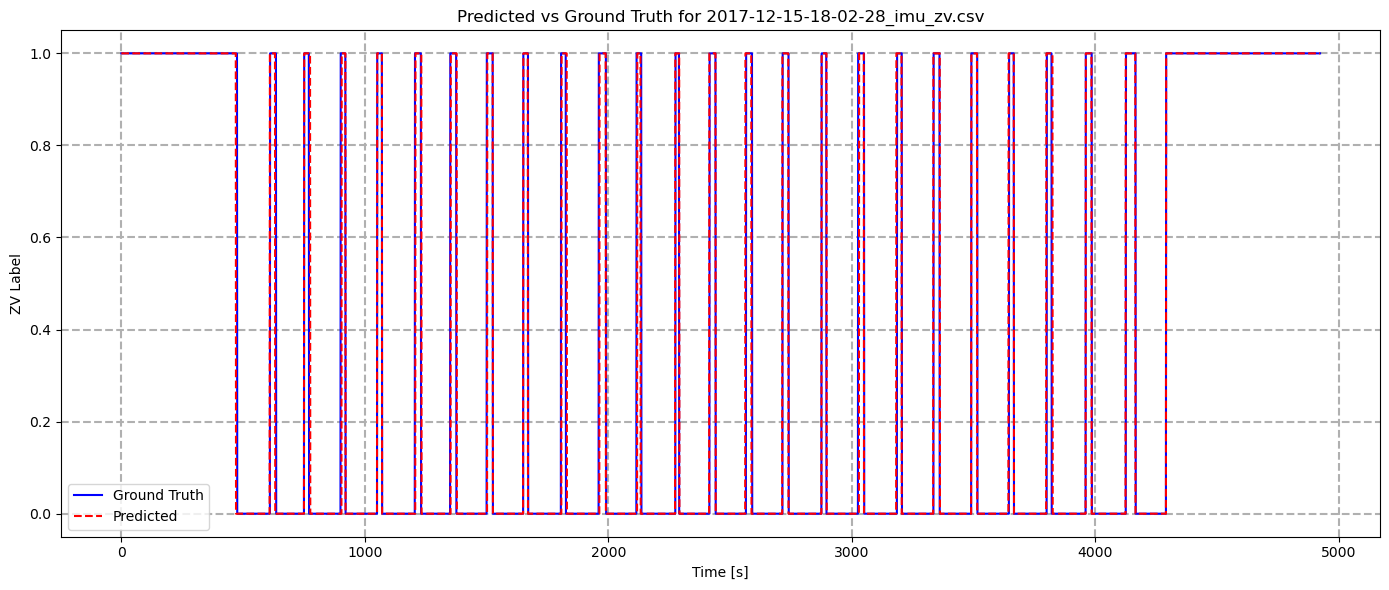

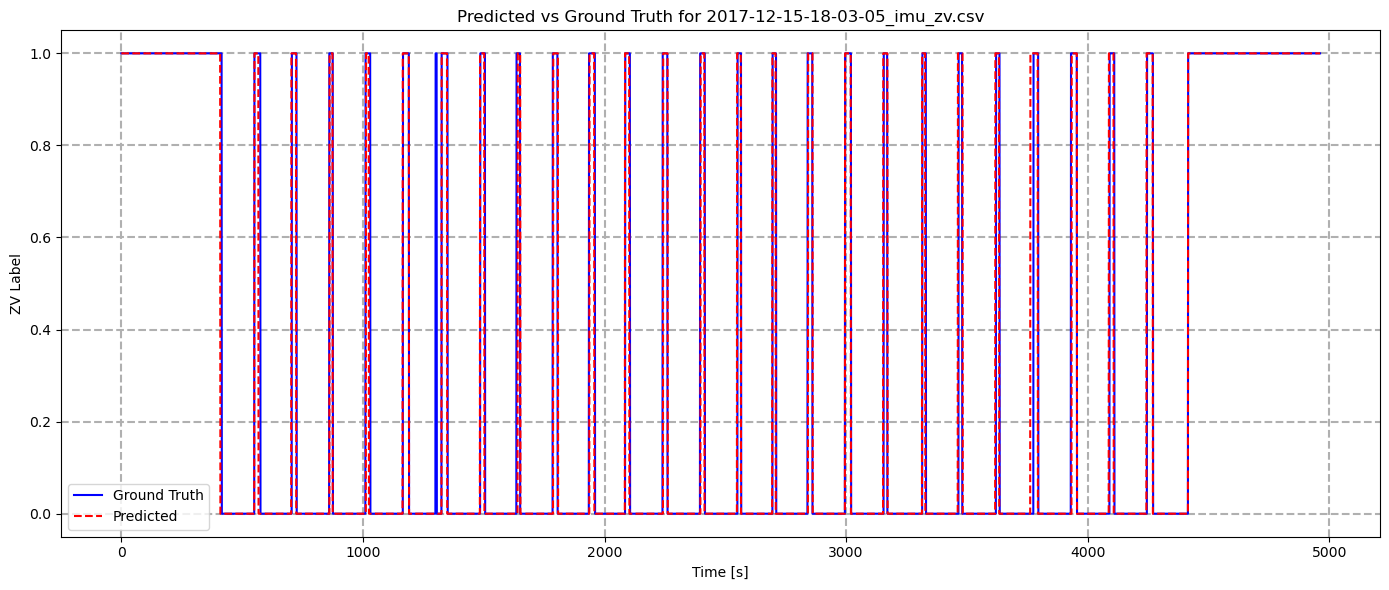

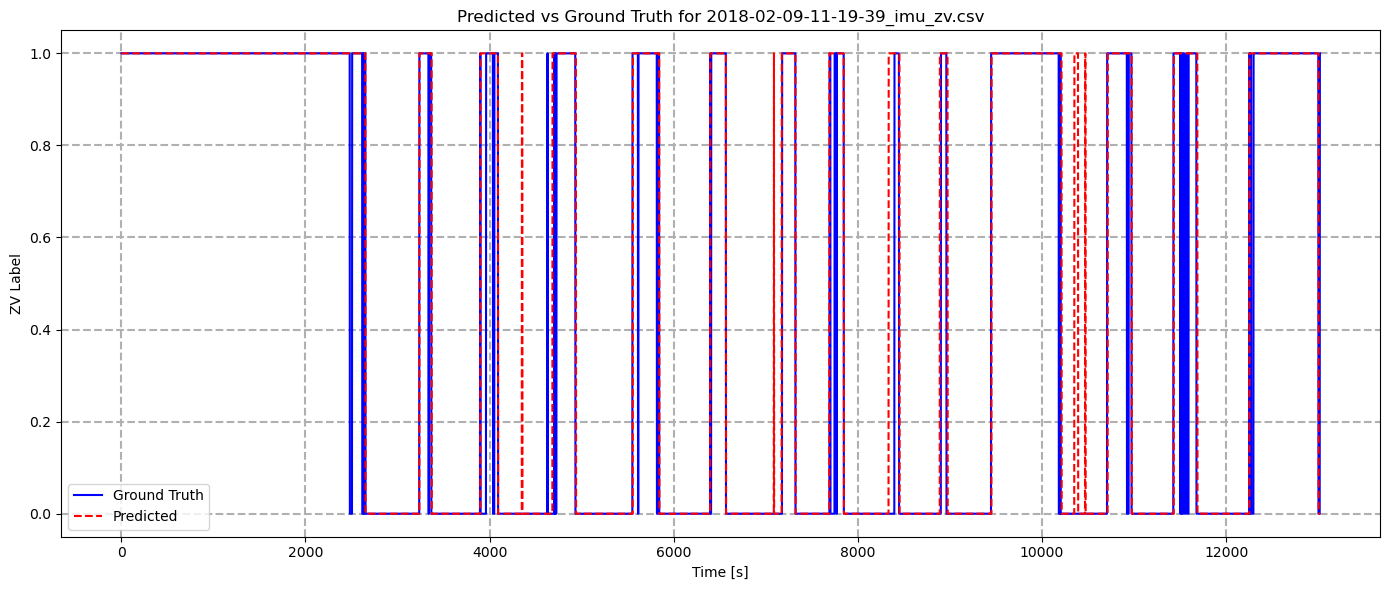

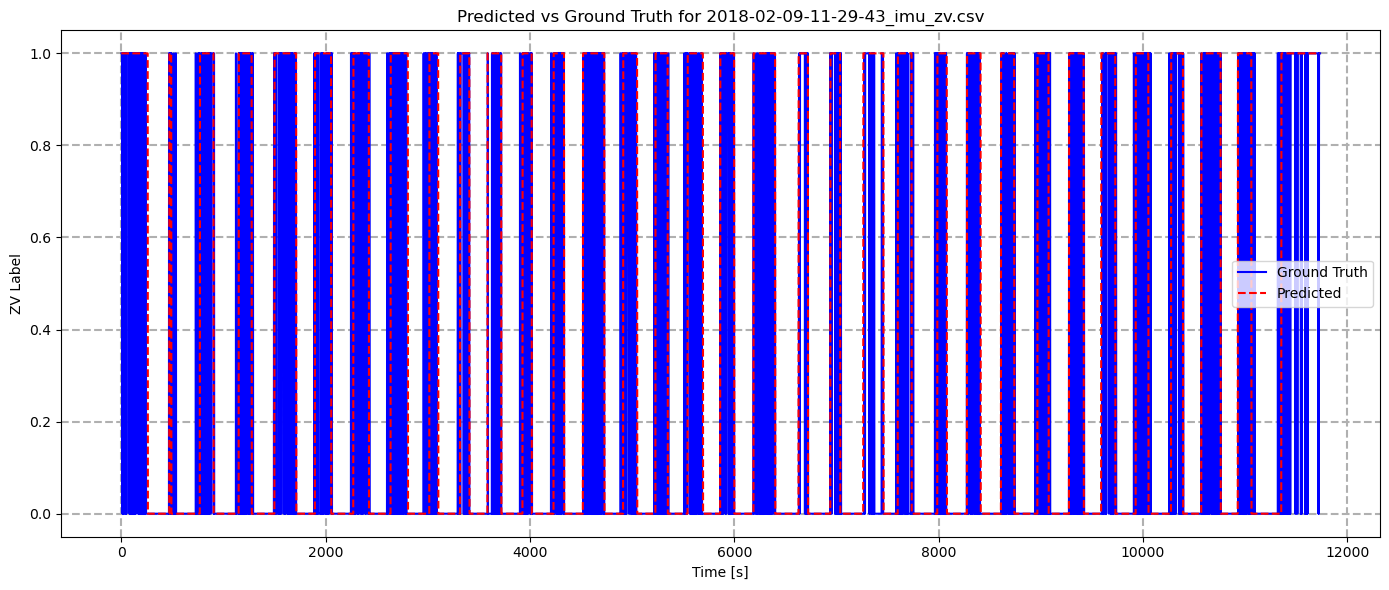

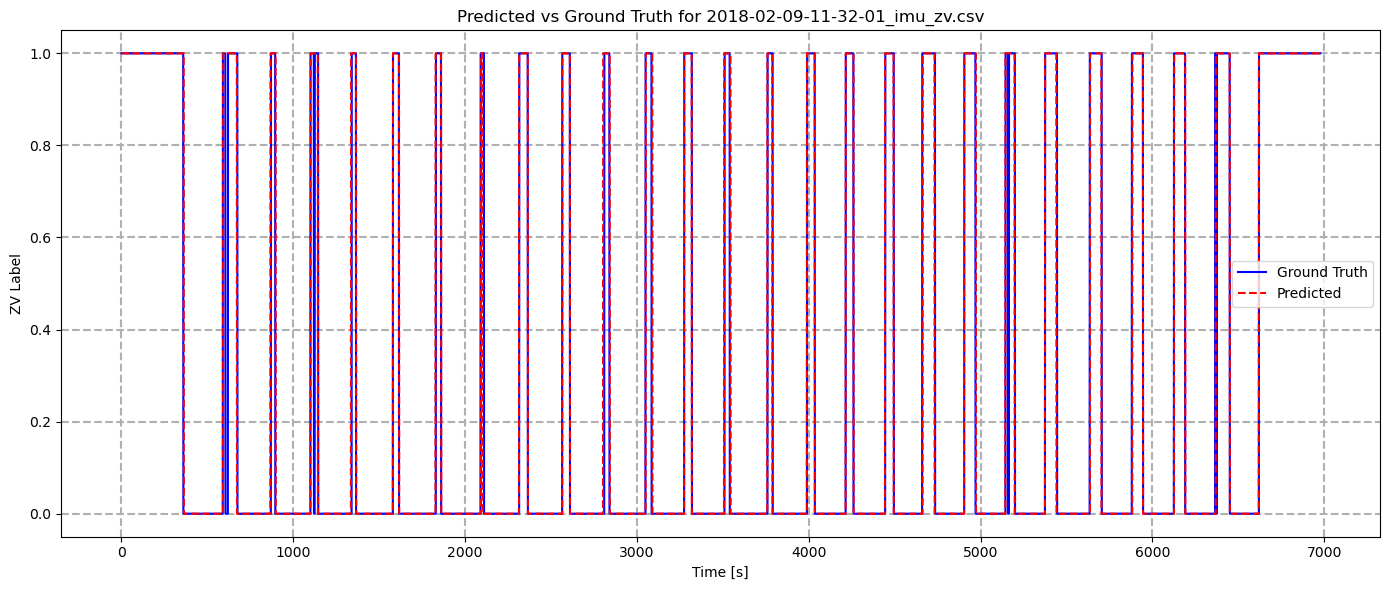

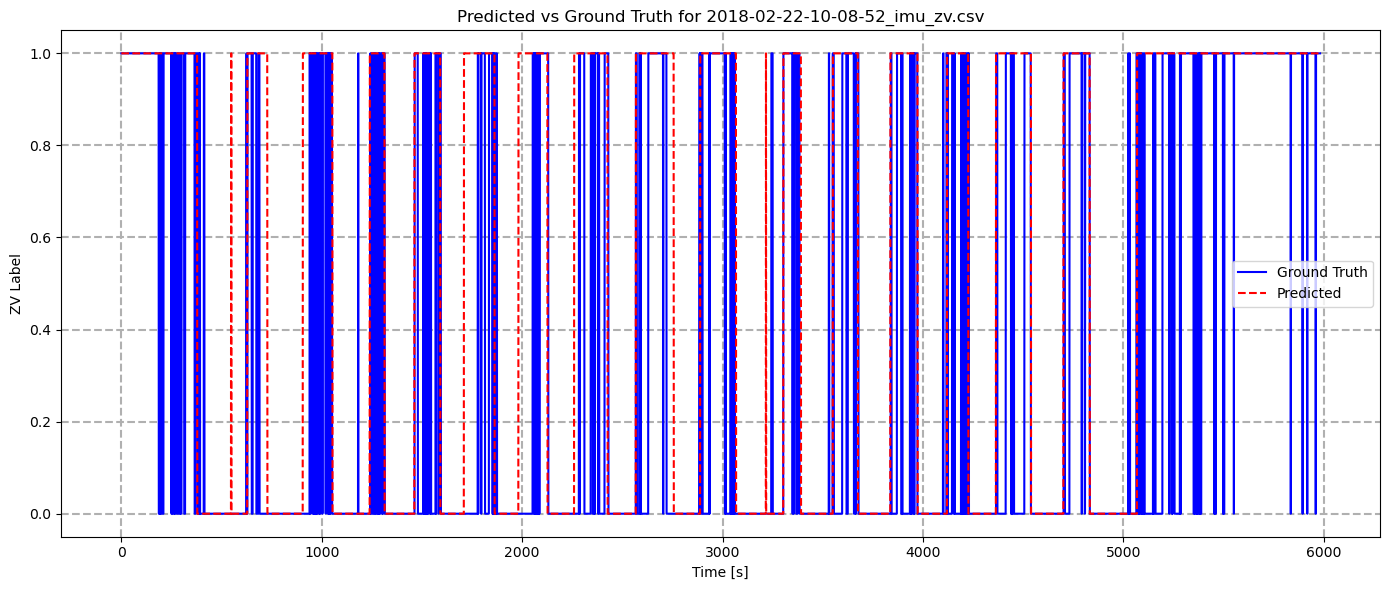

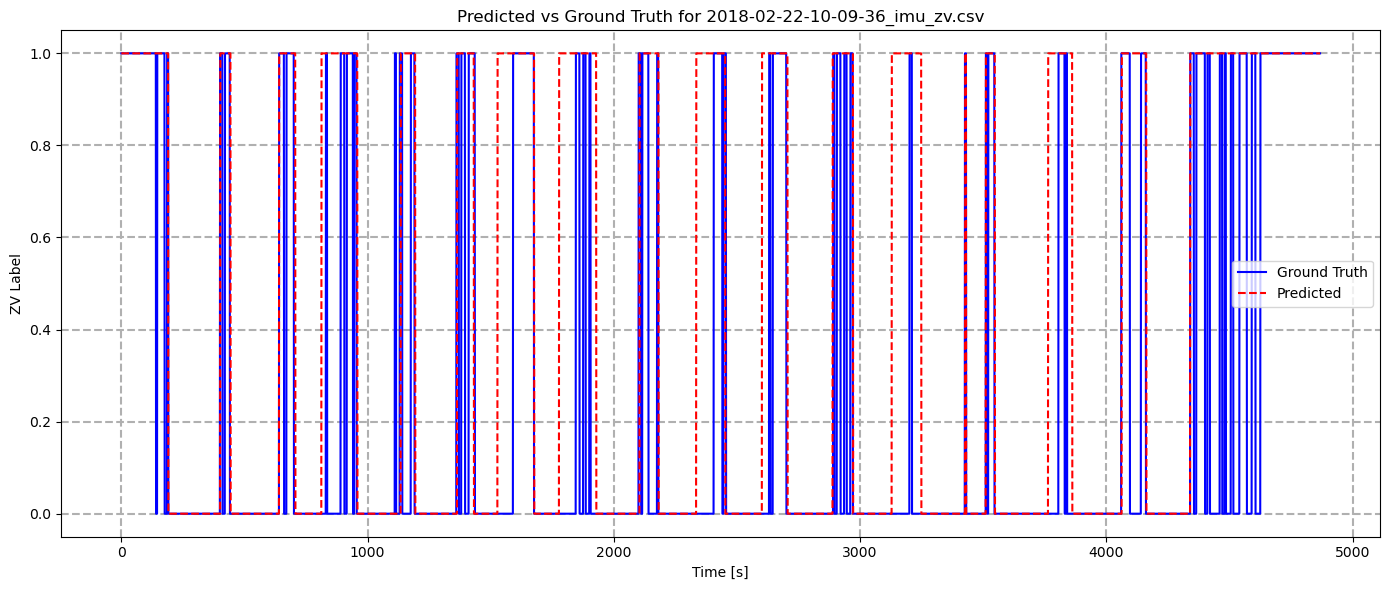

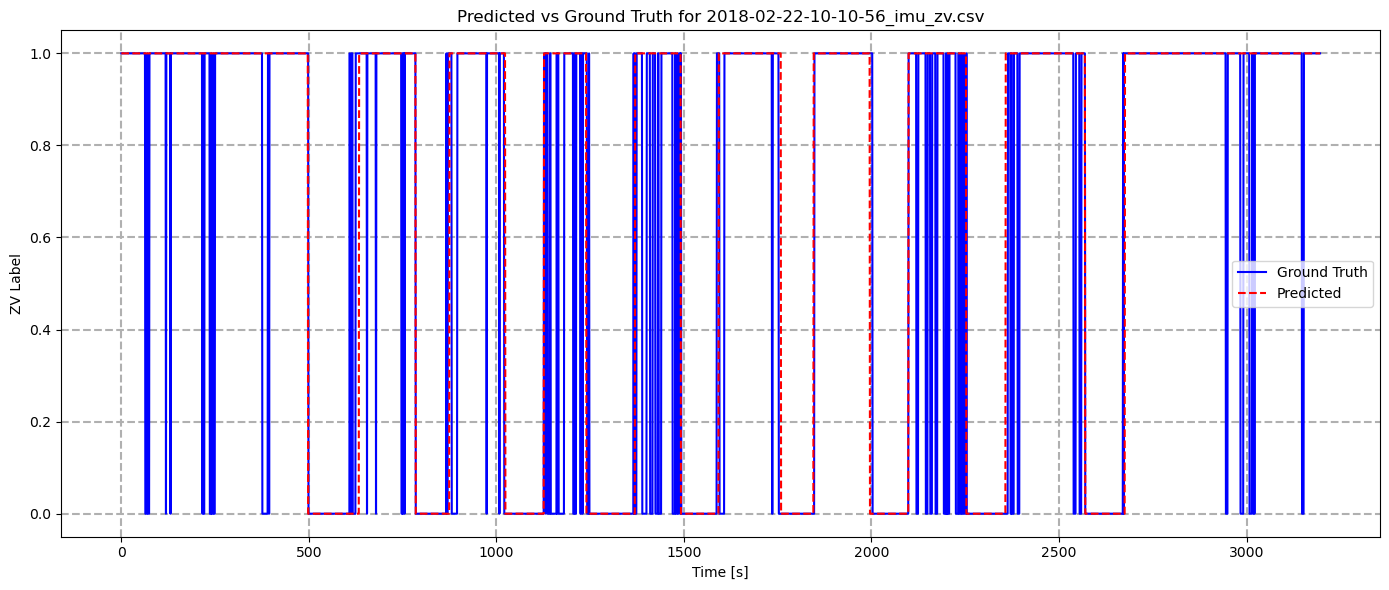

In [2]:
import os
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# LSTM Model definition (same as training)
class LSTM(torch.nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = torch.nn.LSTM(
            input_size=6,
            hidden_size=128,  # Increased hidden size for more model capacity
            num_layers=5,  # Increased number of layers
            batch_first=True,
            dropout=0.1,  # Increased dropout to prevent overfitting
            bidirectional=True,  # Bidirectional LSTM
        )  
        self.fc = torch.nn.Linear(128 * 2, 2)  # Adjusted for bidirectional
        self.dropout = torch.nn.Dropout(0.1)  # Dropout for regularization
        self.batch_norm = torch.nn.BatchNorm1d(128 * 2)  # Batch normalization

    def forward(self, x, h=None):
        batch_size = x.size(0)  # Get batch size from input
        if h is None:
            h_n = x.new_zeros((10, batch_size, 128), device=x.device)  # 5 layers * 2 directions
            h_c = x.new_zeros((10, batch_size, 128), device=x.device)
        else:
            h_n, h_c = h

        self.lstm.flatten_parameters()
        r_out, (h_n, h_c) = self.lstm(x, (h_n, h_c))
        r_out = self.batch_norm(r_out[:, -1, :])  # Apply batch normalization
        r_out = self.dropout(r_out)  # Apply dropout
        output = self.fc(r_out)  # Use the last time step
        return output

# Function to load the data from CSV files (same as in training)
def load_data_from_csv(file_path):
    data = pd.read_csv(file_path)
    imu = data[['ax', 'ay', 'az', 'wx', 'wy', 'wz']].values
    labels = data['zv'].values
    return imu, labels

# Prepare data for prediction (splitting sequences into windows)
def prepare_data_for_prediction(data_dir, window_size=50):
    data = []
    labels = []
    file_paths = []
    num_data_points_per_file = []

    # Loop through all CSV files in the directory
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith('.csv'):
                file_path = os.path.join(root, file)
                imu_data, label_data = load_data_from_csv(file_path)
                
                # Split data into sequences of size window_size
                num_data_points = len(imu_data) - window_size
                num_data_points_per_file.append(num_data_points)
                
                for i in range(num_data_points):
                    window = imu_data[i:i + window_size]
                    label_window = label_data[i + window_size - 1]  # Predict the label for the last time step
                    data.append(window)
                    labels.append(label_window)
                
                # Keep track of the file paths for plotting later
                file_paths.append(file_path)

    data = np.array(data)
    labels = np.array(labels)  # Ensure labels are 1D (target for each sequence)
    
    return data, labels, file_paths, num_data_points_per_file

# Predict using the pretrained model in batches to avoid memory issues
def predict_in_batches(model, data, batch_size, device):
    model = model.to(device)
    model.eval()

    predictions = []
    data_loader = DataLoader(torch.tensor(data, dtype=torch.float32), batch_size=batch_size)

    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            outputs = model(batch)
            predicted_labels = torch.argmax(outputs, dim=1).cpu().numpy()  # Move back to CPU for numpy
            predictions.append(predicted_labels)

    return np.concatenate(predictions)

# this function is used in stride detection
def count_zero_to_one_transitions(arr):
    # Ensure the array is a NumPy array
    arr = np.asarray(arr)
    
    # Find the locations where transitions from 0 to 1 occur
    transitions = np.where((arr[:-1] == 0) & (arr[1:] == 1))[0]
    
    # Return the count and the indexes
    return len(transitions), transitions + 1  # Add 1 to get the index of the '1'

# Function to count one-to-zero transitions to determine stride indexes
def count_one_to_zero_transitions(zv):
    strides = np.where(np.diff(zv) < 0)[0] + 1
    return len(strides), strides

# elimination of incorrect stride detections in raw zv_opt
def heuristic_zv_filter_and_stride_detector(zv, k):
    if zv.dtype == 'bool':
        zv = zv.astype(int)
    zv[:50] = 1 # make sure all labels are zero at the beginning as the foot is stationary
    # detect strides (falling edge of zv binary signal) and respective indexes
    n, strideIndexFall = count_one_to_zero_transitions(zv)
    strideIndexFall = strideIndexFall - 1 # make all stride indexes the last samples of the respective ZUPT phase
    strideIndexFall = np.append(strideIndexFall, len(zv)-1) # last sample is the last stride index
    # detect rising edge indexes of zv labels
    n2, strideIndexRise = count_zero_to_one_transitions(zv)
    for i in range(len(strideIndexRise)):
        if (strideIndexRise[i] - strideIndexFall[i] < k):
            zv[strideIndexFall[i]:strideIndexRise[i]] = 1 # make all samples in between one
    # after the correction is completed, do the stride index detection process again
    n, strideIndexFall = count_one_to_zero_transitions(zv)
    strideIndexFall = strideIndexFall - 1 # make all stride indexes the last samples of the respective ZUPT phase
    strideIndexFall = np.append(strideIndexFall, len(zv)-1) # last sample is the last stride index
    return zv, n, strideIndexFall

# Function to plot predictions and ground truth on the same plot
def plot_predictions(file_path, predicted_labels, ground_truth_labels):
    plt.figure(figsize=(14, 6))
    
    zv_filtered, n, strideIndex = heuristic_zv_filter_and_stride_detector(predicted_labels, 75)
    # Plot both ground truth and predicted labels on the same plot
    plt.plot(ground_truth_labels, label='Ground Truth', color='blue', linewidth=1.5)
    plt.plot(zv_filtered, label='Predicted', color='red', linestyle='--', linewidth=1.5)
    
    plt.title(f'Predicted vs Ground Truth for {os.path.basename(file_path)}')
    plt.xlabel('Time [s]')
    plt.ylabel('ZV Label')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=1.5)

    plt.tight_layout()
    plt.show()

# Main function to load the model, predict, and plot for each dataset
def main():
    # Load the pretrained model
    model = LSTM()
    model.load_state_dict(torch.load('results/pretrained-models/zv_bilstm_model.pth'))

    # Check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    csv_data_dir = 'results/figs/vicon_corrected/lstm_zv_detector_training_data'
    
    # Prepare data for prediction
    data, labels, file_paths, num_data_points_per_file = prepare_data_for_prediction(csv_data_dir, window_size=50)

    # Batch size for prediction to avoid out-of-memory error
    batch_size = 512  # You can adjust this based on GPU memory

    # Predict using the pretrained model in batches
    predicted_labels = predict_in_batches(model, data, batch_size, device)

    # Plot predictions for each file
    start_idx = 0
    for i, file_path in enumerate(file_paths):
        num_data_points = num_data_points_per_file[i]
        end_idx = start_idx + num_data_points
        plot_predictions(file_path, predicted_labels[start_idx:end_idx], labels[start_idx:end_idx])
        start_idx = end_idx

if __name__ == "__main__":
    main()
